Datasets URLs:

*   PetFinder:

    https://www.kaggle.com/datasets/ma7555/cat-breeds-dataset

*   Batogov:

    https://github.com/batogov/cat-breeds-classifier

*   Keypoints:

    https://sites.google.com/view/animal-pose/

# Imports and Dependencies

In [ ]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 10938, done.
remote: Counting objects: 100% (1140/1140), done.
remote: Compressing objects: 100% (592/592), done.
remote: Total 10938 (delta 634), reused 972 (delta 523), pack-reused 9798
Receiving objects: 100% (10938/10938), 45.78 MiB | 17.80 MiB/s, done.
Resolving deltas: 100% (7672/7672), done.


In [ ]:
!pip install pigeon-jupyter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 42.3 MB/s 
  Created wheel for pigeon-jupyter: filename=pigeon_jupyter-0.1.0-py3-none-any.whl size=3881 sha256=a0a33cb6563fb851077083a4c2b5dc80b54bcd7c0c98e464e898c2290bad2aaa
  Stored in directory: /root/.cache/pip/wheels/ff/7b/9b/efba2217e8be7bc17f9b04af207d4585367d706f3bb30fa392
Successfully built pigeon-jupyter


In [ ]:
import os
import sys
import six
import xml
import ast
import glob
import json
import copy
import atexit
import random
import functools
import collections
from pathlib import Path

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow
import skimage
from scipy import ndimage, misc
from IPython.display import display, Image

import PIL.Image
import PIL.ImageFont as ImageFont
import PIL.ImageDraw as ImageDraw
import PIL.ImageColor as ImageColor

import tensorflow as tf
import keras.api._v2.keras as keras
from keras import regularizers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint
from keras.models import Sequential, save_model, load_model, Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers import Conv2D, ConvLSTM2D, Dense, Dropout, Flatten, GaussianNoise, Input, LayerNormalization, MaxPooling2D, RandomContrast, RandomFlip, RandomRotation, Rescaling, Reshape, SpatialDropout2D

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, plot_confusion_matrix, roc_auc_score, f1_score

from google.colab import drive

from pigeon import annotate

import pycocotools.mask as maskUtils
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sys.path.insert(0, 'tpu/models/official/mask_rcnn')
from tpu.models.official.mask_rcnn.coco_metric import generate_segmentation_from_masks
from tpu.models.official.mask_rcnn.object_detection.visualization_utils import draw_mask_on_image_array, draw_bounding_box_on_image_array, draw_keypoints_on_image_array, STANDARD_COLORS


%matplotlib inline
seed = 42

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Breeds

## PetFinder Dataset

### EDA



Loading the original PetFinder dataset csv as a pandas dataframe:

In [ ]:
df_petfinder_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/petfinder/annotations/cats.csv')
df_petfinder_csv

,Unnamed: 0,id,url,type,age,gender,size,coat,breed,photos,med_photos
0,0,46744842,https://www.petfinder.com/cat/arianna-46744842...,Cat,Adult,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
1,1,46717321,https://www.petfinder.com/cat/ozzy-46717321/oh...,Cat,Adult,Male,Extra Large,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
2,2,46626338,https://www.petfinder.com/cat/zena-46626338/ca...,Cat,Senior,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
3,3,46620170,https://www.petfinder.com/cat/mika-46620170/ca...,Cat,Baby,Female,Small,Short,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
4,4,46582751,https://www.petfinder.com/cat/ruby-46582751/fl...,Cat,Young,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
...,...,...,...,...,...,...,...,...,...,...,...
67140,70984,43781057,https://www.petfinder.com/cat/jasper-43781057/...,Cat,Baby,Male,Medium,Short,Tuxedo,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
67141,70985,43773439,https://www.petfinder.com/cat/missy-43773439/o...,Cat,Adult,Female,Medium,Short,Tuxedo,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
67142,70986,43773383,https://www.petfinder.com/cat/bandit-43773383/...,Cat,Young,Female,Large,Short,Tuxedo,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
67143,70987,43773168,https://www.petfinder.com/cat/maxy-43773168/ut...,Cat,Adult,Male,Medium,Medium,Tuxedo,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...


As we can see, the dataset is huge and imbalanced:

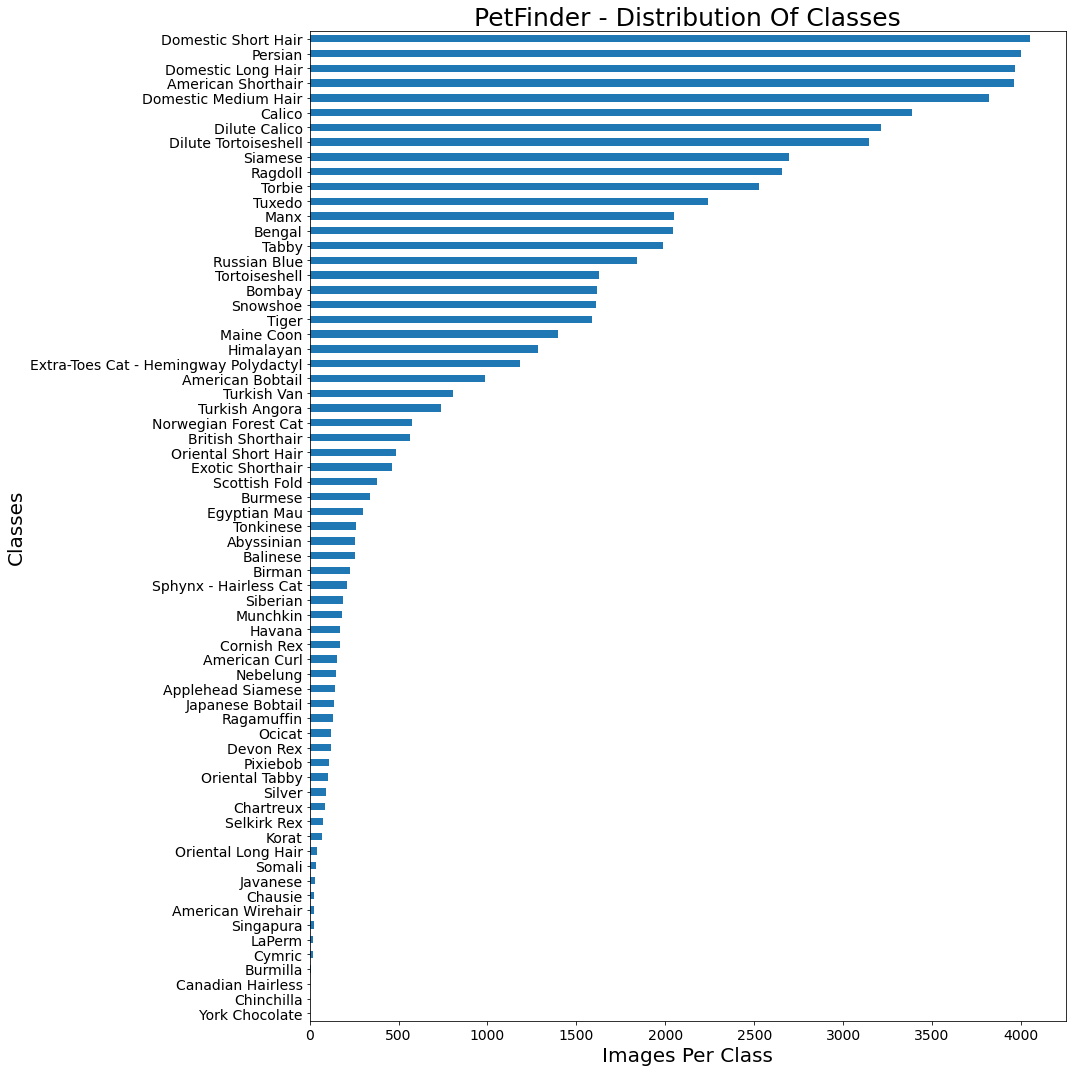

In [ ]:
ax = pd.value_counts(df_petfinder_csv['breed'], ascending=True).plot(kind='barh',
                                                                     fontsize="14",
                                                                     title="PetFinder - Distribution Of Classes",
                                                                     figsize=(15, 15))
ax.set(xlabel="Images Per Class", ylabel="Classes")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(25)
plt.tight_layout()
plt.show()

To compensate, we'll take only 10 labels:

In [ ]:
df_petfinder_csv.breed.value_counts()[:11]

Domestic Short Hair     4049
Persian                 3999
Domestic Long Hair      3967
American Shorthair      3964
Domestic Medium Hair    3819
Calico                  3389
Dilute Calico           3212
Dilute Tortoiseshell    3144
Siamese                 2695
Ragdoll                 2656
Torbie                  2525
Name: breed, dtype: int64

In [ ]:
labels_needed = ['Persian', 'Domestic Long Hair', 'Domestic Medium Hair',
                 'Calico', 'Dilute Calico', 'Dilute Tortoiseshell',
                 'American Shorthair', 'Siamese', 'Ragdoll', 'Torbie']

The images in this dataset are saved online and given as URLs in the csv file. For comfort, we saved the images to our shared Drive folder, and now we can work with them here.

Taking only the files with the labels we want, we create a new dataframe:

In [ ]:
Filepaths = []
Labels = []

for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/petfinder/images'):
    for filename in filenames:
        image_file = os.path.join(dirname, filename)
        label = image_file.split(os.path.sep)[-2]
        if label in labels_needed:
            Filepaths.append(image_file)
            Labels.append(label)

In [ ]:
df_petfinder = pd.DataFrame(list(zip(Filepaths, Labels)), columns=['Filepath', 'Labels'])
df_petfinder

,Filepath,Labels
0,/content/drive/My Drive/Colab Notebooks/FINAL_...,Persian
1,/content/drive/My Drive/Colab Notebooks/FINAL_...,Persian
2,/content/drive/My Drive/Colab Notebooks/FINAL_...,Persian
3,/content/drive/My Drive/Colab Notebooks/FINAL_...,Persian
4,/content/drive/My Drive/Colab Notebooks/FINAL_...,Persian
...,...,...
38103,/content/drive/My Drive/Colab Notebooks/FINAL_...,Domestic Medium Hair
38104,/content/drive/My Drive/Colab Notebooks/FINAL_...,Domestic Medium Hair
38105,/content/drive/My Drive/Colab Notebooks/FINAL_...,Domestic Medium Hair
38106,/content/drive/My Drive/Colab Notebooks/FINAL_...,Domestic Medium Hair


Let's shuffle the items and display the first 12 images, as a random sample:

In [ ]:
df_petfinder = (df_petfinder.sample(frac=1, random_state=seed).reset_index()).drop(columns='index')
df_petfinder

,Filepath,Labels
0,/content/drive/My Drive/Colab Notebooks/FINAL_...,Siamese
1,/content/drive/My Drive/Colab Notebooks/FINAL_...,Domestic Medium Hair
2,/content/drive/My Drive/Colab Notebooks/FINAL_...,American Shorthair
3,/content/drive/My Drive/Colab Notebooks/FINAL_...,Persian
4,/content/drive/My Drive/Colab Notebooks/FINAL_...,Ragdoll
...,...,...
38103,/content/drive/My Drive/Colab Notebooks/FINAL_...,American Shorthair
38104,/content/drive/My Drive/Colab Notebooks/FINAL_...,Torbie
38105,/content/drive/My Drive/Colab Notebooks/FINAL_...,Ragdoll
38106,/content/drive/My Drive/Colab Notebooks/FINAL_...,Persian


In [ ]:
df_petfinder.to_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/petfinder/annotations/df_petfinder.csv')

In [ ]:
df_petfinder = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/petfinder/annotations/df_petfinder.csv', index_col=0)

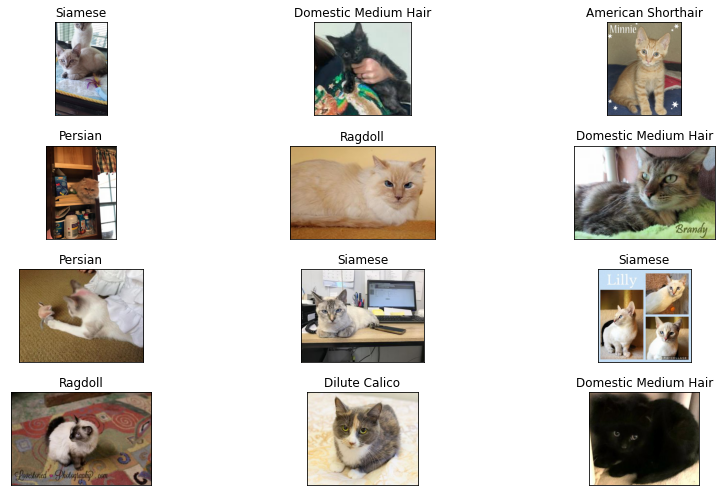

In [ ]:
f, a = plt.subplots(nrows=4, ncols=3, figsize=(13, 7),
                    subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df_petfinder.Filepath[i]))
    ax.set_title(df_petfinder.Labels[i])

plt.tight_layout()
plt.show()

Let's look at the distribution now:

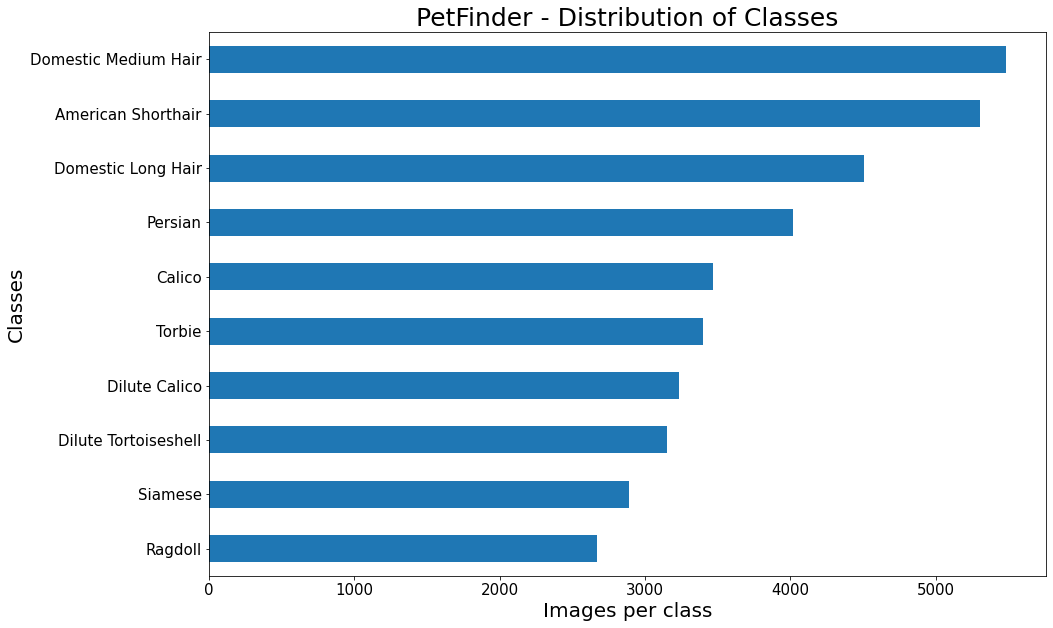

In [ ]:
ax = pd.value_counts(df_petfinder['Labels'], ascending=True).plot(kind='barh',
                                                                  fontsize="15",
                                                                  title="PetFinder - Distribution of Classes",
                                                                  figsize=(15,10))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(25)
plt.show()

### Preprocessing

Train/Test split:

In [ ]:
train_ratio = 0.75
validation_ratio = 0.25
test_ratio = 0.25

In [ ]:
petf_train, petf_test = train_test_split(df_petfinder,
                                         test_size = test_ratio,
                                         random_state=seed,
                                         shuffle=False)

petf_val, petf_test = train_test_split(petf_test,
                                       test_size=test_ratio/(test_ratio + validation_ratio),
                                       random_state=seed,
                                       shuffle=False)

Creating a data generator:

In [ ]:
IMAGE_DIMS = (224, 224, 3)
INIT_LR = 1e-3
EPOCHS = 15
BATCH_SIZE = 10

In [ ]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                 samplewise_center=True,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip='true')

In [ ]:
petf_x_train = img_datagen.flow_from_dataframe(dataframe=petf_train,
                                               x_col='Filepath',
                                               y_col='Labels',
                                               target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               seed=seed)

petf_x_val = img_datagen.flow_from_dataframe(dataframe=petf_val,
                                             x_col='Filepath',
                                             y_col='Labels',
                                             target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             seed=seed)

petf_x_test = img_datagen.flow_from_dataframe(dataframe=petf_test,
                                              x_col='Filepath',
                                              y_col='Labels',
                                              target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                              shuffle=False,
                                              batch_size=BATCH_SIZE,
                                              seed=seed)

Found 28581 validated image filenames belonging to 10 classes.
Found 4763 validated image filenames belonging to 10 classes.
Found 4764 validated image filenames belonging to 10 classes.


In [ ]:
petf_labels = dict([(value, key) for key, value in petf_x_train.class_indices.items()])
petf_labels

{0: 'American Shorthair',
 1: 'Calico',
 2: 'Dilute Calico',
 3: 'Dilute Tortoiseshell',
 4: 'Domestic Long Hair',
 5: 'Domestic Medium Hair',
 6: 'Persian',
 7: 'Ragdoll',
 8: 'Siamese',
 9: 'Torbie'}

We've tried different pretrained models for transfer learning.

In [ ]:
def create_model(pretrained, classes, name=None, denseVal=256, dropVal=0.5):
    model = Sequential([pretrained,
                        GlobalAveragePooling2D(),
                        Dense(denseVal, activation='relu', kernel_initializer='he_uniform',
                              kernel_regularizer=regularizers.l2(0.0175)),
                        Dropout(dropVal, seed=seed),
                        Dense(classes, activation='softmax')],
                       name=name)

    model.layers[0].trainable = False
    model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
    return model

### First Model: MobileNetV2

#### Model Creation

In [ ]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=IMAGE_DIMS)
mnet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
mnet_petfinder = create_model(mnet, classes=10, name='mnet_petfinder')
mnet_petfinder.summary()

Model: "mnet_petfinder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2,588,490
Trainable params: 330,506
No

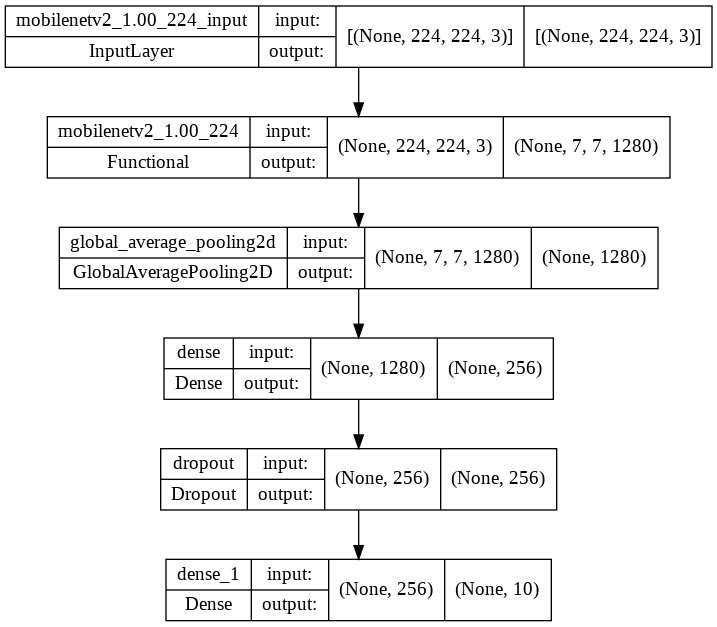

In [ ]:
plot_model(mnet_petfinder,
           to_file='/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_petfinder/mnet_petfinder_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
checkpoint_mnet_petfinder_filepath = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_petfinder/checkpoint_mnet_petfinder'

In [ ]:
checkpoint_mnet_petfinder_callback = ModelCheckpoint(filepath=checkpoint_mnet_petfinder_filepath,
                                                     save_weights_only=True,
                                                     monitor='val_accuracy',
                                                     mode='max',
                                                     save_best_only=True)

#### Model Training

In [ ]:
history_mnet_petfinder = mnet_petfinder.fit(petf_x_train,
                                            validation_data=petf_x_val,
                                            callbacks=[checkpoint_mnet_petfinder_callback],
                                            steps_per_epoch=len(petf_x_train)/BATCH_SIZE,
                                            validation_steps=len(petf_x_val)/BATCH_SIZE,
                                            epochs=EPOCHS,
                                            verbose=1)

Epoch 1/15
285/285 [==============================] - 62s 208ms/step - loss: 10.2239 - accuracy: 0.2566 - val_loss: 9.0909 - val_accuracy: 0.3604
Epoch 2/15
285/285 [==============================] - 72s 251ms/step - loss: 8.4878 - accuracy: 0.3402 - val_loss: 7.6378 - val_accuracy: 0.4479
Epoch 3/15
285/285 [==============================] - 57s 199ms/step - loss: 7.1876 - accuracy: 0.3846 - val_loss: 6.4743 - val_accuracy: 0.4313
Epoch 4/15
285/285 [==============================] - 52s 181ms/step - loss: 6.1677 - accuracy: 0.3967 - val_loss: 5.6231 - val_accuracy: 0.4375
Epoch 5/15
285/285 [==============================] - 59s 207ms/step - loss: 5.3309 - accuracy: 0.4063 - val_loss: 4.8623 - val_accuracy: 0.4563
Epoch 6/15
285/285 [==============================] - 52s 182ms/step - loss: 4.6556 - accuracy: 0.4154 - val_loss: 4.2558 - val_accuracy: 0.4646
Epoch 7/15
285/285 [==============================] - 56s 194ms/step - loss: 4.1178 - accuracy: 0.4084 - val_loss: 3.7652 - val_a

In [ ]:
_ = mnet_petfinder.load_weights(checkpoint_mnet_petfinder_filepath)

In [ ]:
save_model(mnet_petfinder, '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_petfinder/mnet_petfinder_model')

#### Model Application

In [ ]:
mnet_petfinder = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_petfinder/mnet_petfinder_model')

In [ ]:
predictions_mnet_petfinder = mnet_petfinder.predict(petf_x_test)
predictions_mnet_petfinder = np.argmax(predictions_mnet_petfinder, axis=1)
predictions_mnet_petfinder

array([6, 4, 5, ..., 7, 6, 9])

In [ ]:
pred_labels_mnet_petfinder = np.vectorize(petf_labels.get)(predictions_mnet_petfinder)
pred_labels_mnet_petfinder

array(['Persian', 'Domestic Long Hair', 'Domestic Medium Hair', ...,
       'Ragdoll', 'Persian', 'Torbie'], dtype='<U20')

#### Model Evaluation

Accuracy: 0.44710327455919396
F1-score: 0.464680523161637 



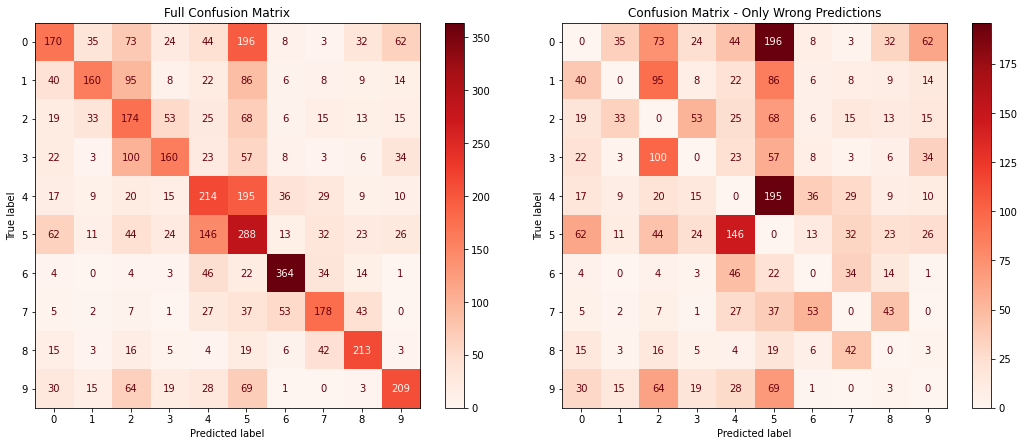

In [ ]:
mnet_petfinder_acc = accuracy_score(petf_test.Labels, pred_labels_mnet_petfinder)
mnet_petfinder_f1 = f1_score(petf_test.Labels,
                             pred_labels_mnet_petfinder,
                             average='macro',
                             zero_division=0)

print('Accuracy:', mnet_petfinder_acc)
print('F1-score:', mnet_petfinder_f1, "\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

mnet_petfinder_martix = confusion_matrix(petf_test.Labels, pred_labels_mnet_petfinder)
ConfusionMatrixDisplay(mnet_petfinder_martix).plot(ax=axes[0], cmap='Reds')
axes[0].title.set_text('Full Confusion Matrix')

np.fill_diagonal(mnet_petfinder_martix, 0)
ConfusionMatrixDisplay(mnet_petfinder_martix).plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Confusion Matrix - Only Wrong Predictions')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(petf_test.Labels,
                            pred_labels_mnet_petfinder,
                            target_names=labels_needed,
                            zero_division=0))

                      precision    recall  f1-score   support

             Persian       0.44      0.26      0.33       647
  Domestic Long Hair       0.59      0.36      0.45       448
Domestic Medium Hair       0.29      0.41      0.34       421
              Calico       0.51      0.38      0.44       416
       Dilute Calico       0.37      0.39      0.38       554
Dilute Tortoiseshell       0.28      0.43      0.34       669
  American Shorthair       0.73      0.74      0.73       492
             Siamese       0.52      0.50      0.51       353
             Ragdoll       0.58      0.65      0.62       326
              Torbie       0.56      0.48      0.51       438

            accuracy                           0.45      4764
           macro avg       0.49      0.46      0.46      4764
        weighted avg       0.47      0.45      0.45      4764



### Second Model: InceptionV3

#### Model Creation

In [ ]:
incep = InceptionV3(weights='imagenet',
                    include_top=False,
                    input_shape=IMAGE_DIMS)
incep.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
incep_petfinder = create_model(incep, classes=10, name='incep_petfinder', denseVal=128, dropVal=0.2)
incep_petfinder.summary()

Model: "incep_petfinder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 22,066,346
Trainable params: 263,562
Non-trainable params: 21,802,784
_________________________________

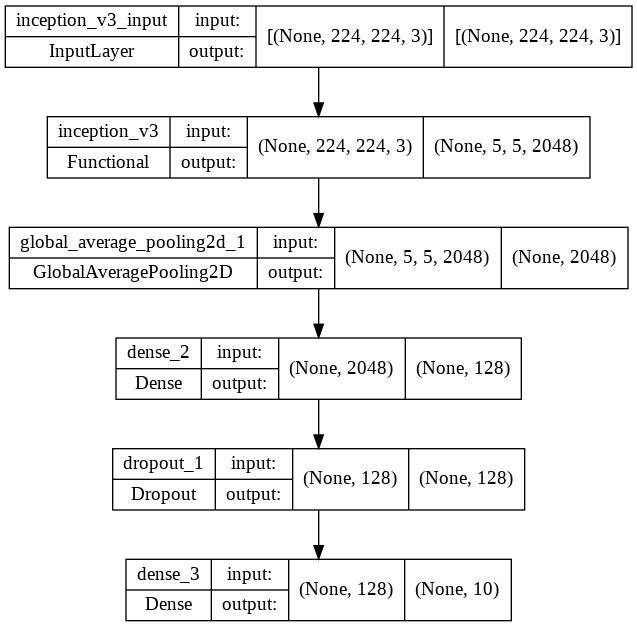

In [ ]:
plot_model(incep_petfinder,
           to_file='/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/incep_petfinder/incep_petfinder_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
checkpoint_incep_petfinder_filepath = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/incep_petfinder/checkpoint_incep_petfinder'

In [ ]:
checkpoint_incep_petfinder_callback = ModelCheckpoint(filepath=checkpoint_incep_petfinder_filepath,
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

#### Model Training

In [ ]:
history_incep_petfinder = incep_petfinder.fit(petf_x_train,
                                              validation_data=petf_x_val,
                                              callbacks=[checkpoint_incep_petfinder_callback],
                                              steps_per_epoch=len(petf_x_train)/BATCH_SIZE,
                                              validation_steps=len(petf_x_val)/BATCH_SIZE,
                                              epochs=EPOCHS,
                                              verbose=1)

Epoch 1/15
285/285 [==============================] - 1090s 4s/step - loss: 5.9101 - accuracy: 0.2948 - val_loss: 5.3058 - val_accuracy: 0.3542
Epoch 2/15
285/285 [==============================] - 809s 3s/step - loss: 5.0682 - accuracy: 0.3510 - val_loss: 4.6213 - val_accuracy: 0.3583
Epoch 3/15
285/285 [==============================] - 760s 3s/step - loss: 4.3965 - accuracy: 0.3808 - val_loss: 4.0681 - val_accuracy: 0.4125
Epoch 4/15
285/285 [==============================] - 657s 2s/step - loss: 3.8786 - accuracy: 0.3920 - val_loss: 3.6134 - val_accuracy: 0.4208
Epoch 5/15
285/285 [==============================] - 586s 2s/step - loss: 3.5185 - accuracy: 0.3979 - val_loss: 3.1970 - val_accuracy: 0.4229
Epoch 6/15
285/285 [==============================] - 577s 2s/step - loss: 3.1492 - accuracy: 0.3955 - val_loss: 2.8832 - val_accuracy: 0.4354
Epoch 7/15
285/285 [==============================] - 475s 2s/step - loss: 2.8824 - accuracy: 0.4192 - val_loss: 2.6495 - val_accuracy: 0.429

In [ ]:
_ = incep_petfinder.load_weights(checkpoint_incep_petfinder_filepath)

In [ ]:
save_model(incep_petfinder, '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/incep_petfinder/incep_petfinder_model')

#### Model Application

In [ ]:
incep_petfinder = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/incep_petfinder/incep_petfinder_model')

In [ ]:
predictions_incep_petfinder = incep_petfinder.predict(petf_x_test)
predictions_incep_petfinder = np.argmax(predictions_incep_petfinder, axis=1)
predictions_incep_petfinder

array([6, 9, 9, ..., 6, 6, 9])

In [ ]:
pred_labels_incep_petfinder = np.vectorize(petf_labels.get)(predictions_incep_petfinder)
pred_labels_incep_petfinder

array(['Persian', 'Torbie', 'Torbie', ..., 'Persian', 'Persian', 'Torbie'],
      dtype='<U20')

#### Model Evaluation

Accuracy: 0.4443744752308984
F1-score: 0.43896381483287145 



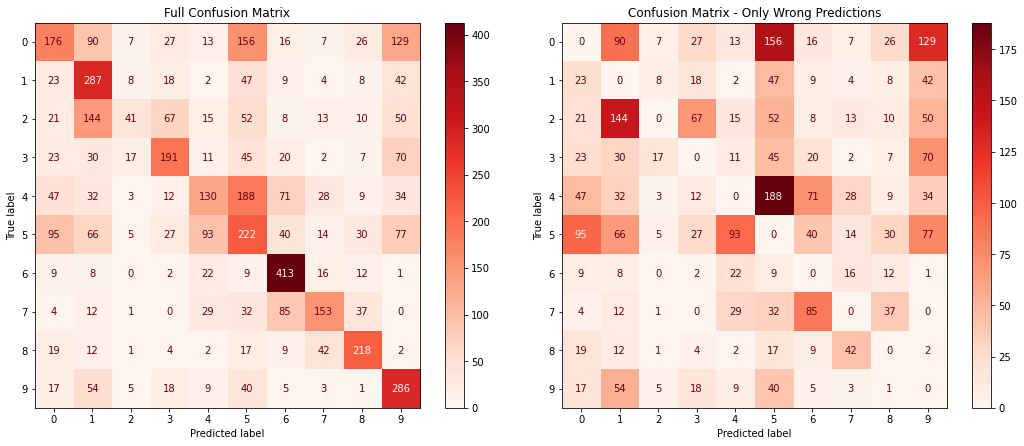

In [ ]:
incep_petfinder_acc = accuracy_score(petf_test.Labels, pred_labels_incep_petfinder)
incep_petfinder_f1 = f1_score(petf_test.Labels,
                              pred_labels_incep_petfinder,
                              average='macro',
                              zero_division=0)

print('Accuracy:', incep_petfinder_acc)
print('F1-score:', incep_petfinder_f1, "\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

incep_petfinder_martix = confusion_matrix(petf_test.Labels, pred_labels_incep_petfinder)
ConfusionMatrixDisplay(incep_petfinder_martix).plot(ax=axes[0], cmap='Reds')
axes[0].title.set_text('Full Confusion Matrix')

np.fill_diagonal(incep_petfinder_martix, 0)
ConfusionMatrixDisplay(incep_petfinder_martix).plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Confusion Matrix - Only Wrong Predictions')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(petf_test.Labels,
                            pred_labels_incep_petfinder,
                            target_names=labels_needed,
                            zero_division=0))

                      precision    recall  f1-score   support

             Persian       0.41      0.27      0.33       647
  Domestic Long Hair       0.39      0.64      0.49       448
Domestic Medium Hair       0.47      0.10      0.16       421
              Calico       0.52      0.46      0.49       416
       Dilute Calico       0.40      0.23      0.30       554
Dilute Tortoiseshell       0.27      0.33      0.30       669
  American Shorthair       0.61      0.84      0.71       492
             Siamese       0.54      0.43      0.48       353
             Ragdoll       0.61      0.67      0.64       326
              Torbie       0.41      0.65      0.51       438

            accuracy                           0.44      4764
           macro avg       0.46      0.46      0.44      4764
        weighted avg       0.45      0.44      0.42      4764



### Third Model: ResNet50

#### Model Creation

In [ ]:
resnet =  tf.keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,
                                         input_shape=IMAGE_DIMS)
resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
resnet_petfinder = create_model(resnet, classes=10, name='resnet_petfinder', denseVal=128, dropVal=0.2)
resnet_petfinder.summary()

Model: "resnet_petfinder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 23,851,274
Trainable params: 263,562
Non-trainable params: 23,587,712
________________________________

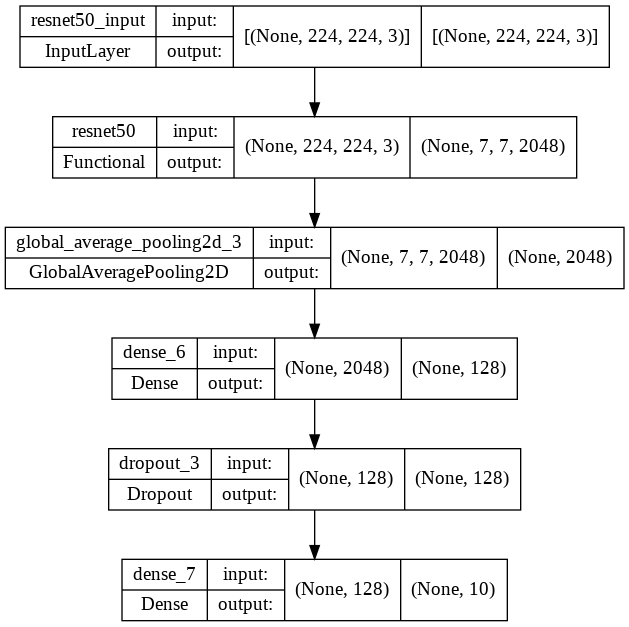

In [ ]:
plot_model(resnet_petfinder,
           to_file='/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/resnet_petfinder/resnet_petfinder_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
checkpoint_resnet_petfinder_filepath = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/resnet_petfinder/checkpoint_resnet_petfinder'

In [ ]:
checkpoint_resnet_petfinder_callback = ModelCheckpoint(filepath=checkpoint_resnet_petfinder_filepath,
                                                       save_weights_only=True,
                                                       monitor='val_accuracy',
                                                       mode='max',
                                                       save_best_only=True)

#### Model Training

In [ ]:
history_resnet_petfinder = resnet_petfinder.fit(petf_x_train,
                                                validation_data=petf_x_val,
                                                callbacks=[checkpoint_resnet_petfinder_callback],
                                                steps_per_epoch=len(petf_x_train)/BATCH_SIZE,
                                                validation_steps=len(petf_x_val)/BATCH_SIZE,
                                                epochs=EPOCHS,
                                                verbose=1)

Epoch 1/15
285/285 [==============================] - 136s 458ms/step - loss: 6.3736 - accuracy: 0.1213 - val_loss: 5.9432 - val_accuracy: 0.1604
Epoch 2/15
285/285 [==============================] - 82s 272ms/step - loss: 5.6008 - accuracy: 0.1367 - val_loss: 5.2623 - val_accuracy: 0.1604
Epoch 3/15
285/285 [==============================] - 120s 409ms/step - loss: 5.0051 - accuracy: 0.1448 - val_loss: 4.7230 - val_accuracy: 0.1375
Epoch 4/15
285/285 [==============================] - 87s 304ms/step - loss: 4.5034 - accuracy: 0.1542 - val_loss: 4.2785 - val_accuracy: 0.1375
Epoch 5/15
285/285 [==============================] - 73s 256ms/step - loss: 4.1015 - accuracy: 0.1449 - val_loss: 3.9092 - val_accuracy: 0.1375
Epoch 6/15
285/285 [==============================] - 72s 252ms/step - loss: 3.7783 - accuracy: 0.1491 - val_loss: 3.6212 - val_accuracy: 0.1375
Epoch 7/15
285/285 [==============================] - 64s 223ms/step - loss: 3.5015 - accuracy: 0.1476 - val_loss: 3.3727 - val_

In [ ]:
_ = resnet_petfinder.load_weights(checkpoint_resnet_petfinder_filepath)

In [ ]:
save_model(resnet_petfinder, '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/resnet_petfinder/resnet_petfinder_model')

#### Model Application

In [ ]:
resnet_petfinder = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/resnet_petfinder/resnet_petfinder_model')

In [ ]:
predictions_resnet_petfinder = resnet_petfinder.predict(petf_x_test)
predictions_resnet_petfinder = np.argmax(predictions_resnet_petfinder, axis=1)
predictions_resnet_petfinder

array([5, 5, 5, ..., 5, 5, 5])

In [ ]:
pred_labels_resnet_petfinder = np.vectorize(petf_labels.get)(predictions_resnet_petfinder)
pred_labels_resnet_petfinder

array(['Domestic Medium Hair', 'Domestic Medium Hair',
       'Domestic Medium Hair', ..., 'Domestic Medium Hair',
       'Domestic Medium Hair', 'Domestic Medium Hair'], dtype='<U20')

#### Model Evaluation

Accuracy: 0.14042821158690177
F1-score: 0.02462727774710105 



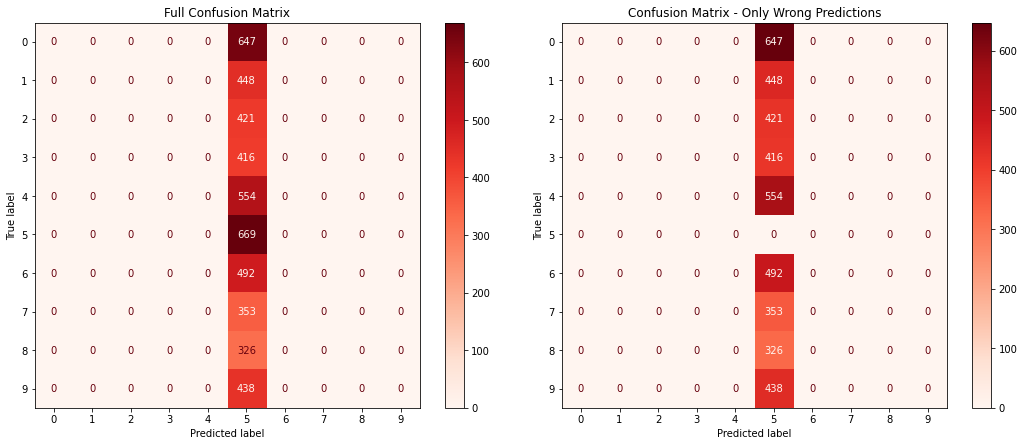

In [ ]:
resnet_petfinder_acc = accuracy_score(petf_test.Labels, pred_labels_resnet_petfinder)
resnet_petfinder_f1 = f1_score(petf_test.Labels,
                               pred_labels_resnet_petfinder,
                               average='macro',
                               zero_division=0)

print('Accuracy:', resnet_petfinder_acc)
print('F1-score:', resnet_petfinder_f1, "\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

resnet_petfinder_martix = confusion_matrix(petf_test.Labels, pred_labels_resnet_petfinder)
ConfusionMatrixDisplay(resnet_petfinder_martix).plot(ax=axes[0], cmap='Reds')
axes[0].title.set_text('Full Confusion Matrix')

np.fill_diagonal(resnet_petfinder_martix, 0)
ConfusionMatrixDisplay(resnet_petfinder_martix).plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Confusion Matrix - Only Wrong Predictions')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(petf_test.Labels,
                            pred_labels_resnet_petfinder,
                            target_names=labels_needed,
                            zero_division=0))

                      precision    recall  f1-score   support

             Persian       0.00      0.00      0.00       647
  Domestic Long Hair       0.00      0.00      0.00       448
Domestic Medium Hair       0.00      0.00      0.00       421
              Calico       0.00      0.00      0.00       416
       Dilute Calico       0.00      0.00      0.00       554
Dilute Tortoiseshell       0.14      1.00      0.25       669
  American Shorthair       0.00      0.00      0.00       492
             Siamese       0.00      0.00      0.00       353
             Ragdoll       0.00      0.00      0.00       326
              Torbie       0.00      0.00      0.00       438

            accuracy                           0.14      4764
           macro avg       0.01      0.10      0.02      4764
        weighted avg       0.02      0.14      0.03      4764



All three models weren't successfull, so we decided to try a more balanced dataset, the Batogov dataset.

## Batogov Dataset

### EDA

Loading the original Batogov dataset csv as a pandas dataframe:

In [ ]:
df_batgov_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/list.txt',
                            delimiter=" ",
                            skiprows=6,
                            names=['ID', 'Class', 'Species', 'Breed'])
df_batgov_csv

,ID,Class,Species,Breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7341,yorkshire_terrier_96,37,2,25
7342,yorkshire_terrier_97,37,2,25
7343,yorkshire_terrier_98,37,2,25
7344,yorkshire_terrier_99,37,2,25


The dataset includes both cats and dogs, so we'll drop the dogs using the dataset's annotations and information:

In [ ]:
df_batgov_csv = df_batgov_csv[df_batgov_csv['Species'] == 1]  # 1 - cat, 2 - dog
df_batgov_csv

,ID,Class,Species,Breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7052,Sphynx_95,34,1,12
7053,Sphynx_96,34,1,12
7054,Sphynx_98,34,1,12
7055,Sphynx_99,34,1,12


The breeds as listed in the dataset's info:

In [ ]:
breeds = {1: 'Abyssinian', 2: 'Bengal', 3: 'Birman', 4: 'Bombay', 5: 'British Shorthair', 6: 'Egyptian Mau',
          7: 'Maine Coon', 8: 'Persian', 9: 'Ragdoll', 10: 'Russian Blue', 11: 'Siamese', 12: 'Sphynx'}

Creating a new, more comfortable and readable dataframe:

In [ ]:
dirname = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/images'

Filepaths = df_batgov_csv['ID'].apply(lambda filename: dirname + '/' + filename + '.jpg')
Labels = df_batgov_csv['Breed'].map(breeds)

df_batogov = pd.DataFrame(list(zip(Filepaths, Labels)), columns=['Filepath', 'Labels'])
df_batogov

,Filepath,Labels
0,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Abyssinian
1,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Abyssinian
2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Abyssinian
3,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Abyssinian
4,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Abyssinian
...,...,...
2363,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Sphynx
2364,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Sphynx
2365,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Sphynx
2366,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Sphynx


As mentioned, this dataset is distributed fairly evenly:

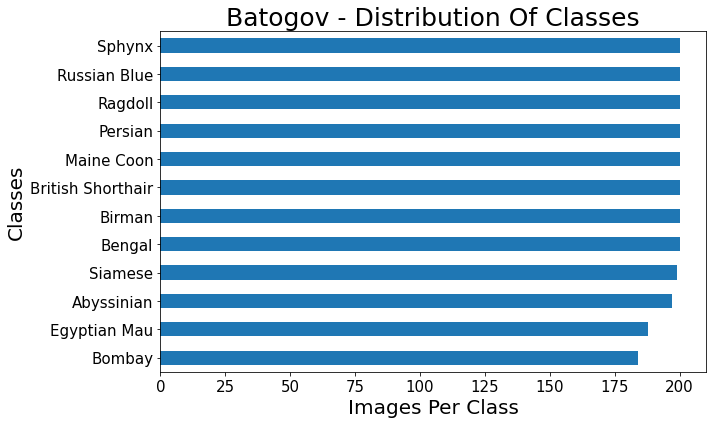

In [ ]:
ax = pd.value_counts(df_batogov['Labels'], ascending=True).plot(kind='barh',
                                                                fontsize="15",
                                                                title="Batogov - Distribution Of Classes",
                                                                figsize=(10, 6))
ax.set(xlabel="Images Per Class", ylabel="Classes")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(25)
plt.tight_layout()
plt.show()

In [ ]:
df_batogov.Labels.value_counts()

Bengal               200
Birman               200
British Shorthair    200
Maine Coon           200
Persian              200
Ragdoll              200
Russian Blue         200
Sphynx               200
Siamese              199
Abyssinian           197
Egyptian Mau         188
Bombay               184
Name: Labels, dtype: int64

Let's shuffle the items and display the first 12 images, as a random sample:

In [ ]:
df_batogov = (df_batogov.sample(frac=1, random_state=seed).reset_index(drop=True))
df_batogov

,Filepath,Labels
0,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Siamese
1,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Bombay
2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Maine Coon
3,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Birman
4,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Bengal
...,...,...
2363,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,British Shorthair
2364,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Siamese
2365,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Siamese
2366,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Bengal


In [ ]:
# df_batogov.to_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/batogov_shuffled.csv')

In [ ]:
df_batogov = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/batogov_shuffled.csv', index_col=0)

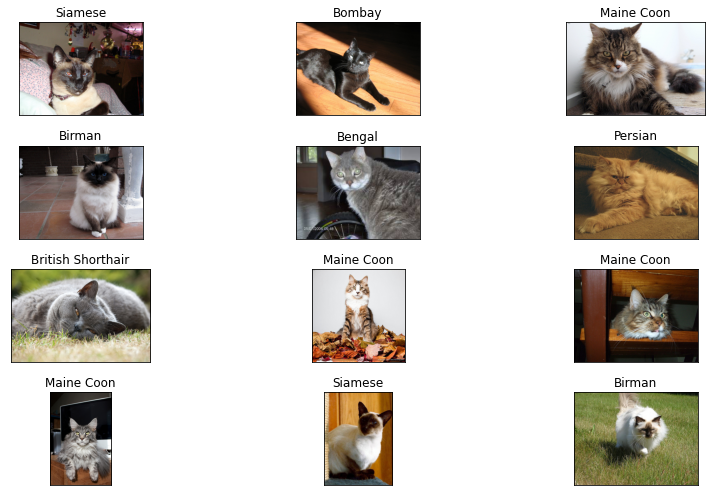

In [ ]:
f, a = plt.subplots(nrows=4, ncols=3, figsize=(13, 7),
                    subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df_batogov.Filepath[i]))
    ax.set_title(df_batogov.Labels[i])

plt.tight_layout()
plt.show()

### Preprocessing

Train/Test split:

In [ ]:
bat_train, bat_test = train_test_split(df_batogov,
                                       test_size = test_ratio,
                                       random_state=seed,
                                       shuffle=False)

bat_val, bat_test = train_test_split(bat_test,
                                     test_size=test_ratio/(test_ratio + validation_ratio),
                                     random_state=seed,
                                     shuffle=False)

Data generation:

In [ ]:
bat_x_train = img_datagen.flow_from_dataframe(dataframe=bat_train,
                                              x_col='Filepath',
                                              y_col='Labels',
                                              target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                              shuffle=False,
                                              batch_size=BATCH_SIZE,
                                              seed=seed)

bat_x_val = img_datagen.flow_from_dataframe(dataframe=bat_val,
                                            x_col='Filepath',
                                            y_col='Labels',
                                            target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                            shuffle=False,
                                            batch_size=BATCH_SIZE,
                                            seed=seed)

bat_x_test = img_datagen.flow_from_dataframe(dataframe=bat_test,
                                             x_col='Filepath',
                                             y_col='Labels',
                                             target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             seed=seed)

Found 1776 validated image filenames belonging to 12 classes.
Found 296 validated image filenames belonging to 12 classes.
Found 296 validated image filenames belonging to 12 classes.


In [ ]:
bat_labels = dict([(value, key) for key, value in bat_x_train.class_indices.items()])
bat_labels

{0: 'Abyssinian',
 1: 'Bengal',
 2: 'Birman',
 3: 'Bombay',
 4: 'British Shorthair',
 5: 'Egyptian Mau',
 6: 'Maine Coon',
 7: 'Persian',
 8: 'Ragdoll',
 9: 'Russian Blue',
 10: 'Siamese',
 11: 'Sphynx'}

### Model Creation

In [ ]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=IMAGE_DIMS)
mnet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
mnet_batogov = create_model(mnet, classes=12, name='mnet_batogov')
mnet_batogov.summary()

Model: "mnet_batogov"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 2,589,004
Trainable params: 331,020
Non-

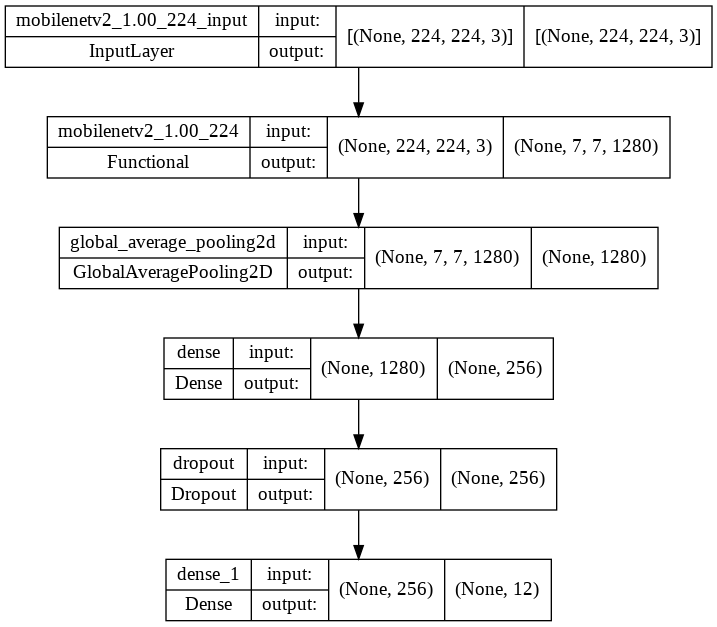

In [ ]:
plot_model(mnet_batogov,
           to_file='/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_batogov/mnet_batogov_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
checkpoint_mnet_batogov_filepath = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_batogov/checkpoint_mnet_batogov'

In [ ]:
checkpoint_mnet_batogov_callback = ModelCheckpoint(filepath=checkpoint_mnet_batogov_filepath,
                                                   save_weights_only=True,
                                                   monitor='val_accuracy',
                                                   mode='max',
                                                   save_best_only=True)

### Model Training

In [ ]:
history_mnet_batogov = mnet_batogov.fit(bat_x_train,
                                        validation_data=bat_x_val,
                                        callbacks=[checkpoint_mnet_batogov_callback],
                                        steps_per_epoch=len(bat_train)/BATCH_SIZE,
                                        validation_steps=len(bat_val)/BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose=1)

Epoch 1/15
177/177 [==============================] - 831s 5s/step - loss: 10.0771 - accuracy: 0.4611 - val_loss: 8.7270 - val_accuracy: 0.7804
Epoch 2/15
177/177 [==============================] - 38s 214ms/step - loss: 8.3592 - accuracy: 0.6988 - val_loss: 7.6404 - val_accuracy: 0.8142
Epoch 3/15
177/177 [==============================] - 37s 210ms/step - loss: 7.3486 - accuracy: 0.7506 - val_loss: 6.7870 - val_accuracy: 0.7838
Epoch 4/15
177/177 [==============================] - 39s 218ms/step - loss: 6.5135 - accuracy: 0.7736 - val_loss: 6.0537 - val_accuracy: 0.8108
Epoch 5/15
177/177 [==============================] - 42s 234ms/step - loss: 5.7709 - accuracy: 0.8024 - val_loss: 5.3961 - val_accuracy: 0.8142
Epoch 6/15
177/177 [==============================] - 37s 211ms/step - loss: 5.1483 - accuracy: 0.8097 - val_loss: 4.8251 - val_accuracy: 0.8209
Epoch 7/15
177/177 [==============================] - 39s 219ms/step - loss: 4.5949 - accuracy: 0.8311 - val_loss: 4.3304 - val_acc

In [ ]:
_ = mnet_batogov.load_weights(checkpoint_mnet_batogov_filepath)

In [ ]:
save_model(mnet_batogov, '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_batogov/mnet_batogov_model')

### Model Application

In [ ]:
mnet_batogov = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_batogov/mnet_batogov_model')

In [ ]:
predictions_mnet_batogov = mnet_batogov.predict(bat_x_test)
predictions_mnet_batogov = np.argmax(predictions_mnet_batogov, axis=1)
predictions_mnet_batogov

array([ 6,  9,  0, 10, 10,  6,  6,  7, 10,  1, 11,  9,  9,  2,  3,  5,  0,
        0,  1, 11,  5,  6,  8,  2, 11,  8,  7,  3, 11,  8,  2,  0,  3,  6,
        9, 10,  3,  0,  0, 11, 11,  0,  9,  9,  3,  7,  0,  9,  9,  6, 11,
        9,  5,  9,  9,  7, 11,  0, 10,  0, 11,  2,  9,  3, 11,  1, 10,  9,
        3,  5,  7, 11,  5,  7,  7,  1, 10,  5,  8,  2,  2,  4, 11,  0,  5,
        9,  8, 11,  5,  8, 10,  9,  1,  2,  5, 11,  0,  6,  9,  4,  2,  2,
        7,  0, 10,  7,  4,  6,  5,  2,  3,  8,  1, 11,  6,  6,  3, 11,  0,
        6,  3,  5,  3,  8,  2,  4,  4,  2,  5,  5,  5, 11, 11,  4,  5,  5,
        4,  0,  0,  9,  2,  9,  1, 10,  3,  6, 11, 11,  4,  2,  5,  1,  0,
        6,  0, 10,  2,  2,  0,  8,  7,  1, 10,  2,  3,  8,  3,  4,  1, 11,
       11,  9,  9,  4,  4,  6,  5, 11,  9, 10,  0,  5,  7,  1,  8, 11,  5,
        3,  7,  9,  4,  7,  5,  2, 11,  8,  3,  7,  3,  7,  9,  4,  1, 10,
        3,  6,  4, 10,  9, 11,  6,  7,  8,  0,  7,  3, 11,  3,  8, 11,  1,
        1, 10, 11,  9,  7

In [ ]:
pred_labels_mnet_batogov = np.vectorize(bat_labels.get)(predictions_mnet_batogov)
pred_labels_mnet_batogov

array(['Maine Coon', 'Russian Blue', 'Abyssinian', 'Siamese', 'Siamese',
       'Maine Coon', 'Maine Coon', 'Persian', 'Siamese', 'Bengal',
       'Sphynx', 'Russian Blue', 'Russian Blue', 'Birman', 'Bombay',
       'Egyptian Mau', 'Abyssinian', 'Abyssinian', 'Bengal', 'Sphynx',
       'Egyptian Mau', 'Maine Coon', 'Ragdoll', 'Birman', 'Sphynx',
       'Ragdoll', 'Persian', 'Bombay', 'Sphynx', 'Ragdoll', 'Birman',
       'Abyssinian', 'Bombay', 'Maine Coon', 'Russian Blue', 'Siamese',
       'Bombay', 'Abyssinian', 'Abyssinian', 'Sphynx', 'Sphynx',
       'Abyssinian', 'Russian Blue', 'Russian Blue', 'Bombay', 'Persian',
       'Abyssinian', 'Russian Blue', 'Russian Blue', 'Maine Coon',
       'Sphynx', 'Russian Blue', 'Egyptian Mau', 'Russian Blue',
       'Russian Blue', 'Persian', 'Sphynx', 'Abyssinian', 'Siamese',
       'Abyssinian', 'Sphynx', 'Birman', 'Russian Blue', 'Bombay',
       'Sphynx', 'Bengal', 'Siamese', 'Russian Blue', 'Bombay',
       'Egyptian Mau', 'Persian', 'Sphy

### Model Evaluation

Accuracy: 0.847972972972973
F1-score: 0.8398310130787169 



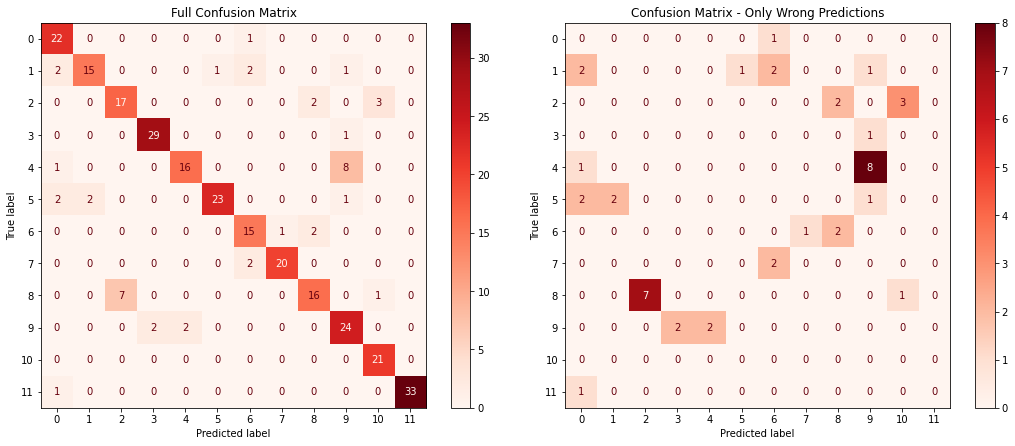

In [ ]:
mnet_batogov_acc = accuracy_score(bat_test.Labels, pred_labels_mnet_batogov)
mnet_batogov_f1 = f1_score(bat_test.Labels,
                           pred_labels_mnet_batogov,
                           average='macro',
                           zero_division=0)

print('Accuracy:', mnet_batogov_acc)
print('F1-score:', mnet_batogov_f1, "\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

mnet_batogov_martix = confusion_matrix(bat_test.Labels, pred_labels_mnet_batogov)
ConfusionMatrixDisplay(mnet_batogov_martix).plot(ax=axes[0], cmap='Reds')
axes[0].title.set_text('Full Confusion Matrix')

np.fill_diagonal(mnet_batogov_martix, 0)
ConfusionMatrixDisplay(mnet_batogov_martix).plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Confusion Matrix - Only Wrong Predictions')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(bat_test.Labels,
                            pred_labels_mnet_batogov,
                            target_names=bat_labels.values(),
                            zero_division=0))

                   precision    recall  f1-score   support

       Abyssinian       0.79      0.96      0.86        23
           Bengal       0.88      0.71      0.79        21
           Birman       0.71      0.77      0.74        22
           Bombay       0.94      0.97      0.95        30
British Shorthair       0.89      0.64      0.74        25
     Egyptian Mau       0.96      0.82      0.88        28
       Maine Coon       0.75      0.83      0.79        18
          Persian       0.95      0.91      0.93        22
          Ragdoll       0.80      0.67      0.73        24
     Russian Blue       0.69      0.86      0.76        28
          Siamese       0.84      1.00      0.91        21
           Sphynx       1.00      0.97      0.99        34

         accuracy                           0.85       296
        macro avg       0.85      0.84      0.84       296
     weighted avg       0.86      0.85      0.85       296



# Poses

Looking for different ways to implement a classification machine, we needed an annotated dataset with different poses. Neither the PetFinder nor the Batogov datasets had annotations related to poses, so we looked for a different one.

We tried implementing the concept of keypoints: the machine learns the locations of specific keypoints in the cat's body, and connects them to a full body position.

We found the Keypoints dataset, with annotated keypoints and bounding boxes.

## Keypoints

At first we cloned the github (https://github.com/noahcao/animal-pose-dataset) but there were things we wanted to customize, and cloning the github doesn't save the customizations in the next run of the notebook, so instead we copied all the functions we needed and customized them in the notebook.

The following is unchanged:

In [ ]:
face_color = (100, 200, 5)
limb_color = (0, 255, 0)
other_color = (200, 200, 50)
kp_color = (0, 0, 255)

segm_colors = [face_color] * 5 + [other_color] * 2 + [limb_color] * 4 + [other_color] * 4

def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))


def draw_keypoint(im, keypoints):
    '''
        order:
        0-4 (face): left eye, right eye, nose, left earbase, right earbase
        5-16 (limbs):   L_F_elbow, R_F_elbow, L_B_elbow, R_B_elbow
                        L_F_knee, R_F_knee, L_B_knee, R_B_knee
                        L_F_paw, R_F_paw, L_B_paw, R_B_paw
        17-19 (others): throat, withers, tailbase
    '''
    segmts = [  (0,1), (0,2), (1,2), (0,3), (1,4),
                (2,17), (18,19),
                (5,9), (6,10), (7,11), (8,12),
                (9,13), (10,14), (11,15), (12,16)]


    for i in range(len(segmts)):
        segm = segmts[i]
        kp1 = keypoints[segm[0]]
        kp2 = keypoints[segm[1]]
        if kp1[2] == 0 or kp2[2] == 0:
            continue

        cv2.line(im, tuple(kp1[:2]), tuple(kp2[:2]), segm_colors[i], thickness=2)

    for kp in keypoints:
        if kp[2] == 0:
            continue
        cv2.circle(im, tuple(kp[:2]), radius=4, color=kp_color, thickness=-1)

    return im


def draw_bbox(im, xmin, ymin, xmax, ymax, color):
    cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color, thickness=2)
    return im

The original purpose of the next function was to draw the keypoints on the images themselves and save them. We wanted to get a blank image with only the keypoints drawn, so the model could learn poses from just the keypoints.

In [ ]:
def altered_visualize_json():
    output_dir = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/visualization_animalpose_blank_bg'
    os.makedirs(output_dir, exist_ok=True)
    anno_dict = json.load(open('/content/drive/My Drive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/keypoints.json'))
    image_map = anno_dict['images']
    annotations = anno_dict['annotations']
    im_dict = dict()
    for anno in annotations:
        imagename = image_map[str(anno['image_id'])]
        bbox = anno['bbox']
        keypoints = anno['keypoints']
        image_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/images', imagename)
        if not imagename in im_dict:
            im = cv2.imread(image_path)
        else:
            im = im_dict[imagename]
        im = np.zeros(im.shape, np.uint8)
        xmin, ymin, xmax, ymax = bbox
        im = draw_bbox(im, xmin, ymin, xmax, ymax, random_color())
        im = draw_keypoint(im, keypoints)
        save_path = os.path.join(output_dir, imagename)
        cv2.imwrite(save_path, im)
        im_dict[imagename] = im

No need to run it again since the images are already created and saved:

In [ ]:
# altered_visualize_json()

In [ ]:
original_image = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/images/2007_001825.jpg'
keypoints_image = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/visualization_animalpose/2007_001825.jpg'
keypoints_blank = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/visualization_animalpose_blank_bg/2007_001825.jpg'

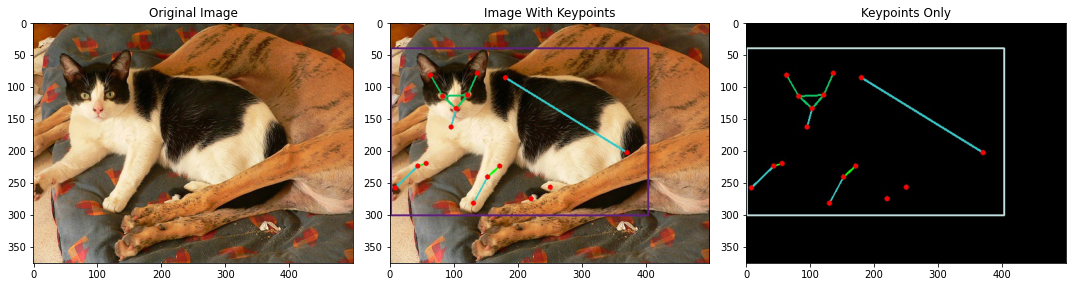

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

axes[0].imshow(plt.imread(original_image))
axes[0].title.set_text('Original Image')

axes[1].imshow(plt.imread(keypoints_image))
axes[1].title.set_text('Image With Keypoints')

axes[2].imshow(plt.imread(keypoints_blank))
axes[2].title.set_text('Keypoints Only')

plt.tight_layout()
plt.show()

After obtaining a keypoints dataset, we realized in order to implement it the way we planned we still had to assign different meanings to different poses.

So we started a new process of annotating the dataset ourselves.

## Annotations

We used the dataset's json file to create a readable dataframe:

In [ ]:
# Opening JSON file
f = open('/content/drive/My Drive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/keypoints.json')

# returns JSON object as
# a dictionary
keypoints_data = json.load(f)

# Closing file
f.close()

The dataset includes many different animals, and we needed only cats.

In [ ]:
df_keypoints = pd.DataFrame(keypoints_data['annotations'])
df_keypoints = df_keypoints[df_keypoints['category_id'] == 2]  # category_id 2 is cats
df_keypoints

,image_id,bbox,keypoints,num_keypoints,category_id
8,8,"[124, 68, 319, 310]","[[273, 158, 1], [225, 150, 1], [243, 180, 1], ...",20,2
9,9,"[1, 49, 341, 499]","[[207, 247, 1], [64, 240, 1], [132, 324, 1], [...",20,2
15,15,"[117, 31, 376, 329]","[[219, 125, 1], [169, 118, 1], [192, 152, 1], ...",20,2
16,15,"[261, 14, 398, 132]","[[336, 96, 1], [296, 85, 1], [312, 112, 1], [3...",20,2
26,19,"[197, 199, 289, 323]","[[237, 233, 1], [223, 240, 1], [235, 245, 1], ...",20,2
...,...,...,...,...,...
5312,3804,"[1, 22, 193, 298]","[[119, 74, 1], [87, 80, 1], [99, 93, 1], [143,...",20,2
5313,3805,"[17, 0, 259, 222]","[[167, 51, 1], [139, 51, 1], [149, 71, 1], [18...",20,2
5314,3806,"[55, 17, 287, 273]","[[161, 92, 1], [131, 91, 1], [146, 105, 1], [1...",20,2
5315,3807,"[26, 22, 194, 286]","[[148, 105, 1], [113, 100, 1], [126, 128, 1], ...",20,2


Adding a cloumn with the filepaths:

In [ ]:
new_col = []
for id in df_keypoints['image_id']:
  new_col.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/images', keypoints_data['images'][str(id)]))

df_keypoints['path'] = new_col
df_keypoints

,image_id,bbox,keypoints,num_keypoints,category_id,path
8,8,"[124, 68, 319, 310]","[[273, 158, 1], [225, 150, 1], [243, 180, 1], ...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
9,9,"[1, 49, 341, 499]","[[207, 247, 1], [64, 240, 1], [132, 324, 1], [...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
15,15,"[117, 31, 376, 329]","[[219, 125, 1], [169, 118, 1], [192, 152, 1], ...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
16,15,"[261, 14, 398, 132]","[[336, 96, 1], [296, 85, 1], [312, 112, 1], [3...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
26,19,"[197, 199, 289, 323]","[[237, 233, 1], [223, 240, 1], [235, 245, 1], ...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
...,...,...,...,...,...,...
5312,3804,"[1, 22, 193, 298]","[[119, 74, 1], [87, 80, 1], [99, 93, 1], [143,...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
5313,3805,"[17, 0, 259, 222]","[[167, 51, 1], [139, 51, 1], [149, 71, 1], [18...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
5314,3806,"[55, 17, 287, 273]","[[161, 92, 1], [131, 91, 1], [146, 105, 1], [1...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
5315,3807,"[26, 22, 194, 286]","[[148, 105, 1], [113, 100, 1], [126, 128, 1], ...",20,2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...


The dataset includes some pictures with multiple cats in them:

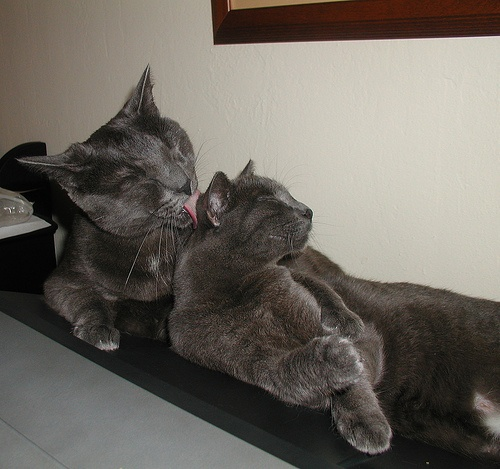

In [ ]:
mult = Image('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/images/2007_007098.jpg')
display(mult)

To handle this type of data, we decided to annotate multiple cats pictures as a single cat with a single pose, only if all cats in the photo share the same pose. We skipped multiple cats photos where each cat is in a different pose.

In addition, we skipped photos we were unable to determine the pose for them.

(No need to run it again, the annotations already exist and are saved in a csv file. For viewing purposes we added the output of the interactive annotation function).

In [ ]:
# annotations_keys = annotate(list(df_keypoints['path']),
#                             options=['sit', 'stand', 'lying'],
#                             display_fn=lambda filename: display(Image(filename))
#                             )

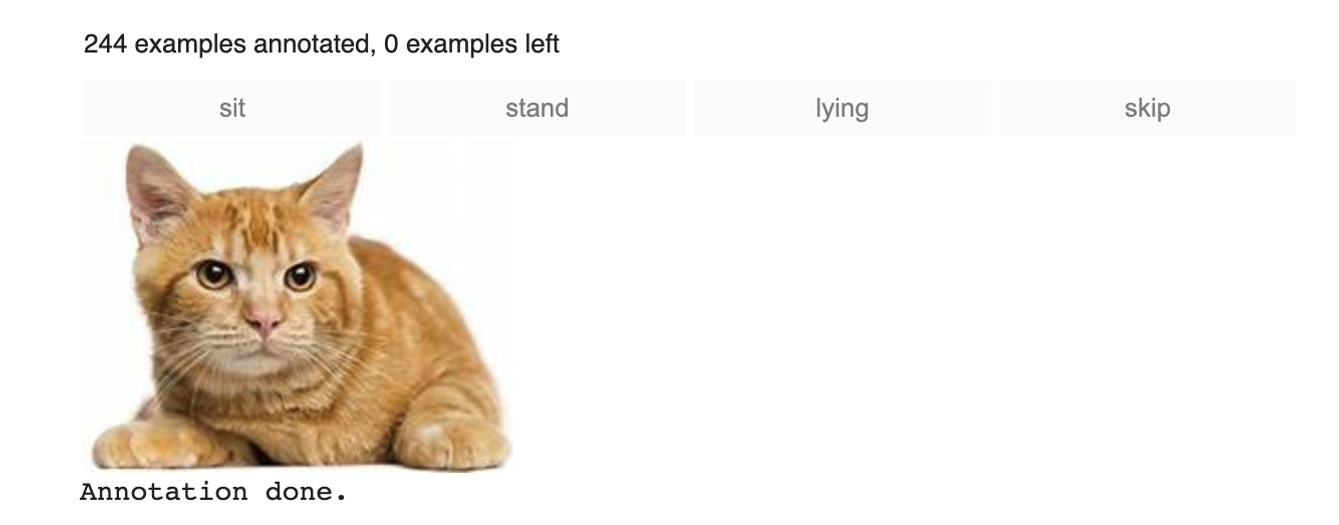

In [ ]:
annotation_output = cv2.imread('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/anotatation_output.png')
cv2_imshow(annotation_output)

In [ ]:
# df_annotations_keys = pd.DataFrame(annotations_keys, columns=['image_path', 'pose'])
# df_annotations_keys

In [ ]:
# df_annotations_keys.to_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/poses.csv')

## EDA

Loading the annotated pose dataset as a pandas dataframe:

In [ ]:
df_poses = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/poses.csv', index_col=0)
df_poses = (df_poses.sample(frac=1, random_state=seed).reset_index(drop=True))
df_poses

,image_path,pose
0,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying
1,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying
2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit
3,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit
4,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying
...,...,...
1018,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying
1019,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying
1020,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying
1021,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit


In [ ]:
df_poses.to_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/poses_shuffled.csv')

In [ ]:
df_poses = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/poses_shuffled.csv', index_col=0)

Let's display the first 12 images:

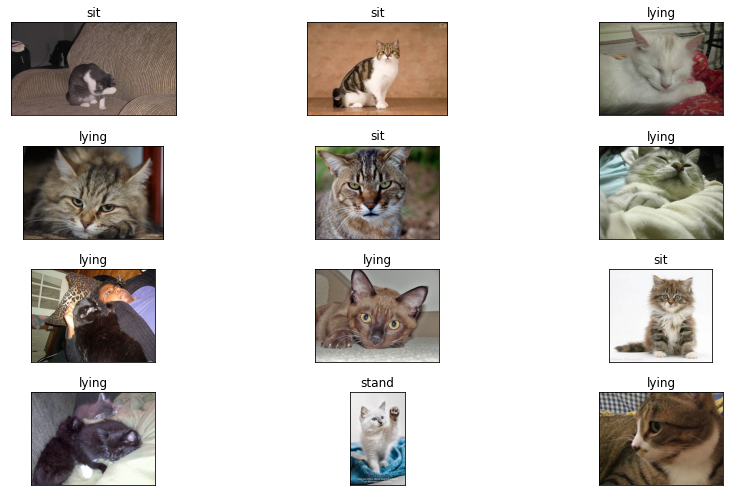

In [ ]:
f, a = plt.subplots(nrows=4, ncols=3,figsize=(13, 7),
                    subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df_poses.image_path[i]))
    ax.set_title(df_poses.pose[i])

plt.tight_layout()
plt.show()

We can see the dataset is imbalanced:

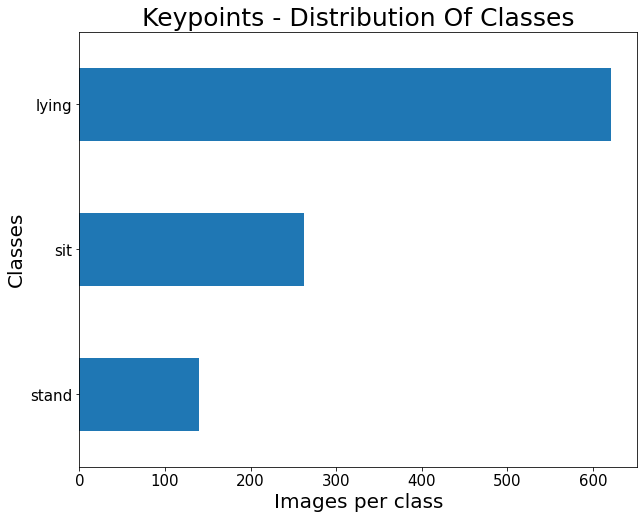

In [ ]:
ax = pd.value_counts(df_poses['pose'], ascending=True).plot(kind='barh',
                                                            fontsize="15",
                                                            title="Keypoints - Distribution Of Classes",
                                                            figsize=(10,8))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(25)
plt.show()

## Preprocessing

Train/Test split:

In [ ]:
pose_train, pose_test = train_test_split(df_poses,
                                         test_size = test_ratio,
                                         random_state=seed,
                                         shuffle=False)

pose_val, pose_test = train_test_split(pose_test,
                                       test_size=test_ratio/(test_ratio + validation_ratio),
                                       random_state=seed,
                                       shuffle=False)

Data generation:

In [ ]:
pose_x_train = img_datagen.flow_from_dataframe(dataframe=pose_train,
                                               x_col='image_path',
                                               y_col='pose',
                                               target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               seed=seed)

pose_x_val = img_datagen.flow_from_dataframe(dataframe=pose_val,
                                             x_col='image_path',
                                             y_col='pose',
                                             target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             seed=seed)

pose_x_test = img_datagen.flow_from_dataframe(dataframe=pose_test,
                                              x_col='image_path',
                                              y_col='pose',
                                              target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                              shuffle=False,
                                              batch_size=BATCH_SIZE,
                                              seed=seed)

Found 767 validated image filenames belonging to 3 classes.
Found 128 validated image filenames belonging to 3 classes.
Found 128 validated image filenames belonging to 3 classes.


In [ ]:
pose_labels = dict([(value, key) for key, value in pose_x_train.class_indices.items()])
pose_labels

{0: 'lying', 1: 'sit', 2: 'stand'}

## Naive Model

First we wanted to try the naive approach, and train a model with the dataset we annotated as is, as a baseline model. No keypoints or other changes made.

### Model Creation

In [ ]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=IMAGE_DIMS)
mnet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
mnet_naive_pose = create_model(mnet, classes=3, name='mnet_naive_pose')
mnet_naive_pose.summary()

Model: "mnet_naive_pose"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,586,691
Trainable params: 328,707
N

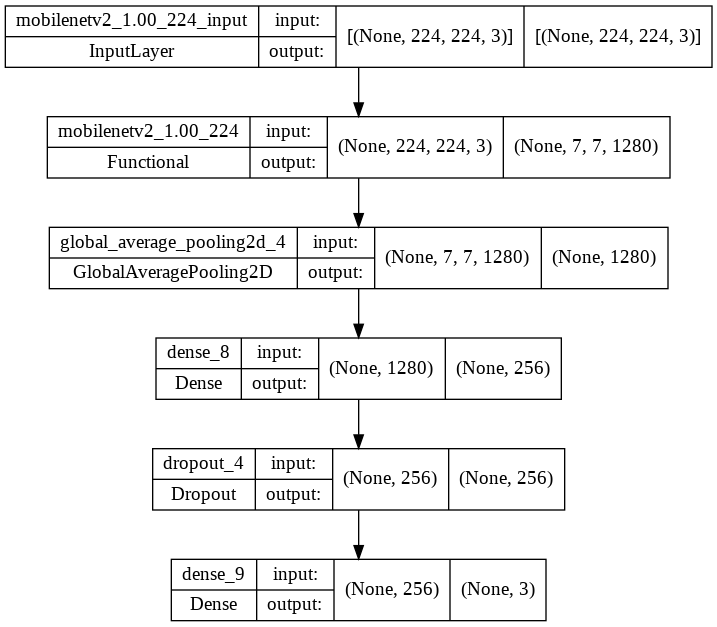

In [ ]:
plot_model(mnet_naive_pose,
           to_file='/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_naive_pose/mnet_naive_pose_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
checkpoint_mnet_naive_pose_filepath = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_naive_pose/checkpoint_mnet_naive_pose'

In [ ]:
checkpoint_mnet_naive_pose_callback = ModelCheckpoint(filepath=checkpoint_mnet_naive_pose_filepath,
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

### Model Training

In [ ]:
history_mnet_naive_pose = mnet_naive_pose.fit(pose_x_train,
                                              validation_data=pose_x_val,
                                              callbacks=[checkpoint_mnet_naive_pose_callback],
                                              steps_per_epoch=len(pose_train)/BATCH_SIZE,
                                              validation_steps=len(pose_val)/BATCH_SIZE,
                                              epochs=EPOCHS,
                                              verbose=1)

Epoch 1/15
76/76 [==============================] - 19s 203ms/step - loss: 9.7672 - accuracy: 0.5828 - val_loss: 9.3345 - val_accuracy: 0.5938
Epoch 2/15
76/76 [==============================] - 16s 210ms/step - loss: 9.0890 - accuracy: 0.6402 - val_loss: 8.9237 - val_accuracy: 0.6094
Epoch 3/15
76/76 [==============================] - 15s 191ms/step - loss: 8.5821 - accuracy: 0.6845 - val_loss: 8.4162 - val_accuracy: 0.6328
Epoch 4/15
76/76 [==============================] - 16s 206ms/step - loss: 8.1364 - accuracy: 0.6988 - val_loss: 8.0358 - val_accuracy: 0.6250
Epoch 5/15
76/76 [==============================] - 14s 188ms/step - loss: 7.7068 - accuracy: 0.7445 - val_loss: 7.6155 - val_accuracy: 0.6719
Epoch 6/15
76/76 [==============================] - 14s 188ms/step - loss: 7.3536 - accuracy: 0.7093 - val_loss: 7.3418 - val_accuracy: 0.6250
Epoch 7/15
76/76 [==============================] - 16s 212ms/step - loss: 6.9551 - accuracy: 0.7432 - val_loss: 6.9773 - val_accuracy: 0.6562

In [ ]:
_ = mnet_naive_pose.load_weights(checkpoint_mnet_naive_pose_filepath)

In [ ]:
save_model(mnet_naive_pose, '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_naive_pose/mnet_naive_pose_model')

### Model Application

In [ ]:
mnet_naive_pose = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_naive_pose/mnet_naive_pose_model')

In [ ]:
predictions_mnet_naive = mnet_naive_pose.predict(pose_x_test)
predictions_mnet_naive = np.argmax(predictions_mnet_naive, axis=1)
predictions_mnet_naive

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0])

In [ ]:
pred_labels_mnet_naive = np.vectorize(pose_labels.get)(predictions_mnet_naive)
pred_labels_mnet_naive

array(['lying', 'stand', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'sit', 'lying', 'lying', 'lying', 'sit', 'stand',
       'stand', 'lying', 'lying', 'sit', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying', 'sit', 'lying', 'stand', 'stand',
       'stand', 'lying', 'lying', 'lying', 'lying', 'lying', 'sit', 'sit',
       'lying', 'lying', 'lying', 'sit', 'lying', 'lying', 'lying',
       'lying', 'sit', 'lying', 'stand', 'lying', 'lying', 'lying',
       'lying', 'lying', 'sit', 'lying', 'lying', 'lying', 'lying',
       'lying', 'stand', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'sit', 'lying', 'lying', 'stand', 'sit', 'lying',
       'lying', 'lying', 'stand', 'lying', 'lying', 'lying', 'stand',
       'sit', 'sit', 'lying', 'stand', 'sit', 'lying', 'lying', 'sit',
       'lying', 'lying', 'sit', 'lying', 'lying', 'sit', 'lying', 'sit',
       'lying', 'lying', 'lying', 'lying', 'lying', 'sit', 'lying',
       'lying

### Model Evaluation

Accuracy: 0.6796875
F1-score: 0.5548384012239433 



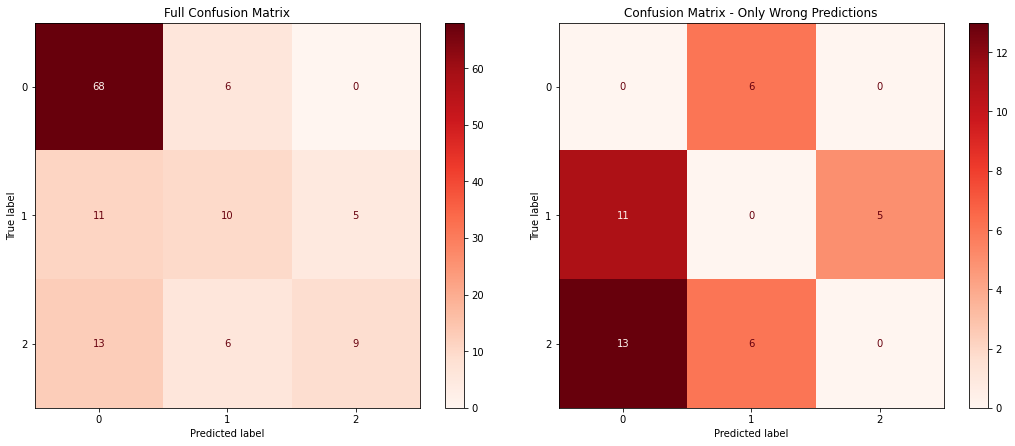

In [ ]:
mnet_naive_pose_acc = accuracy_score(pose_test.pose, pred_labels_mnet_naive)
mnet_naive_pose_f1 = f1_score(pose_test.pose,
                              pred_labels_mnet_naive,
                              average='macro',
                              zero_division=0)

print('Accuracy:', mnet_naive_pose_acc)
print('F1-score:', mnet_naive_pose_f1, "\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

mnet_naive_pose_martix = confusion_matrix(pose_test.pose, pred_labels_mnet_naive)
ConfusionMatrixDisplay(mnet_naive_pose_martix).plot(ax=axes[0], cmap='Reds')
axes[0].title.set_text('Full Confusion Matrix')

np.fill_diagonal(mnet_naive_pose_martix, 0)
ConfusionMatrixDisplay(mnet_naive_pose_martix).plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Confusion Matrix - Only Wrong Predictions')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(pose_test.pose,
                            pred_labels_mnet_naive,
                            target_names=pose_labels.values(),
                            zero_division=0))

              precision    recall  f1-score   support

       lying       0.74      0.92      0.82        74
         sit       0.45      0.38      0.42        26
       stand       0.64      0.32      0.43        28

    accuracy                           0.68       128
   macro avg       0.61      0.54      0.55       128
weighted avg       0.66      0.68      0.65       128



## Class Weights

As we've seen in the EDA part, the Keypoints dataset is highly imbalanced. Thus, we tried to overcome the imbalance with balanced class weights.

### Model Creation

In [ ]:
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(pose_train.pose),
                                     y=pose_train.pose)
class_weights = {i: class_weights[i] for i in range(3)}
class_weights

{0: 0.5416666666666666, 1: 1.2471544715447154, 2: 2.8407407407407406}

In [ ]:
mnet_balanced_pose = create_model(mnet, classes=3, name='mnet_balanced_pose')
mnet_balanced_pose.summary()

Model: "mnet_balanced_pose"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               327936    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 2,586,691
Trainable params: 328,70

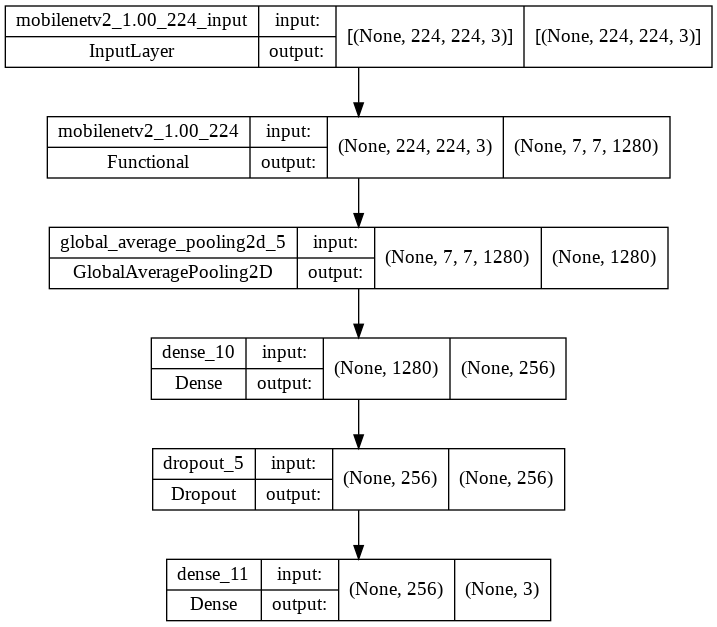

In [ ]:
plot_model(mnet_balanced_pose,
           to_file='/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_balanced_pose/mnet_balanced_pose_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
checkpoint_mnet_balanced_pose_filepath = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_balanced_pose/checkpoint_mnet_balanced_pose'

In [ ]:
checkpoint_mnet_balanced_pose_callback = ModelCheckpoint(filepath=checkpoint_mnet_balanced_pose_filepath,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         mode='max',
                                                         save_best_only=True)

### Model Training

In [ ]:
history_mnet_balanced_pose = mnet_balanced_pose.fit(pose_x_train,
                                                    validation_data=pose_x_val,
                                                    callbacks=[checkpoint_mnet_balanced_pose_callback],
                                                    steps_per_epoch=len(pose_train)/BATCH_SIZE,
                                                    validation_steps=len(pose_val)/BATCH_SIZE,
                                                    epochs=EPOCHS,
                                                    verbose=1,
                                                    class_weight=class_weights)

Epoch 1/15
76/76 [==============================] - 18s 206ms/step - loss: 10.0491 - accuracy: 0.4198 - val_loss: 9.5070 - val_accuracy: 0.4297
Epoch 2/15
76/76 [==============================] - 15s 193ms/step - loss: 9.2600 - accuracy: 0.5515 - val_loss: 8.9014 - val_accuracy: 0.6016
Epoch 3/15
76/76 [==============================] - 15s 191ms/step - loss: 8.7906 - accuracy: 0.5632 - val_loss: 8.4652 - val_accuracy: 0.6328
Epoch 4/15
76/76 [==============================] - 16s 203ms/step - loss: 8.2941 - accuracy: 0.6180 - val_loss: 8.0893 - val_accuracy: 0.6328
Epoch 5/15
76/76 [==============================] - 14s 186ms/step - loss: 7.8709 - accuracy: 0.6610 - val_loss: 7.6946 - val_accuracy: 0.6250
Epoch 6/15
76/76 [==============================] - 14s 187ms/step - loss: 7.4658 - accuracy: 0.6610 - val_loss: 7.3256 - val_accuracy: 0.6172
Epoch 7/15
76/76 [==============================] - 14s 186ms/step - loss: 7.1091 - accuracy: 0.6923 - val_loss: 7.0306 - val_accuracy: 0.578

In [ ]:
_ = mnet_balanced_pose.load_weights(checkpoint_mnet_balanced_pose_filepath)

In [ ]:
save_model(mnet_balanced_pose, '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_balanced_pose/mnet_balanced_pose_model')

### Model Application

In [ ]:
mnet_balanced_pose = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_balanced_pose/mnet_balanced_pose_model')

In [ ]:
predictions_mnet_balanced = mnet_balanced_pose.predict(pose_x_test)
predictions_mnet_balanced = np.argmax(predictions_mnet_balanced, axis=1)
predictions_mnet_balanced

array([0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0,
       2, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0])

In [ ]:
pred_labels_mnet_balanced = np.vectorize(pose_labels.get)(predictions_mnet_balanced)
pred_labels_mnet_balanced

array(['lying', 'stand', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'stand', 'lying', 'lying', 'lying', 'sit', 'stand', 'sit',
       'sit', 'lying', 'lying', 'sit', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'sit', 'lying', 'sit', 'stand', 'stand', 'lying',
       'lying', 'lying', 'lying', 'lying', 'sit', 'stand', 'sit', 'lying',
       'lying', 'stand', 'lying', 'lying', 'lying', 'lying', 'sit',
       'lying', 'sit', 'stand', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'stand',
       'sit', 'sit', 'lying', 'sit', 'lying', 'lying', 'stand', 'lying',
       'lying', 'lying', 'stand', 'stand', 'sit', 'lying', 'lying', 'sit',
       'lying', 'lying', 'lying', 'stand', 'lying', 'sit', 'lying', 'sit',
       'lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'stand',
       'lying', 'stand', 'stand', 'lying', 'sit', 'lying', 'lying',
       'lying', 'sit', 'lying', 'sit', 'sit', 'lying', 'lying',

### Model Evaluation

Accuracy: 0.7734375
F1-score: 0.7188115330520394 



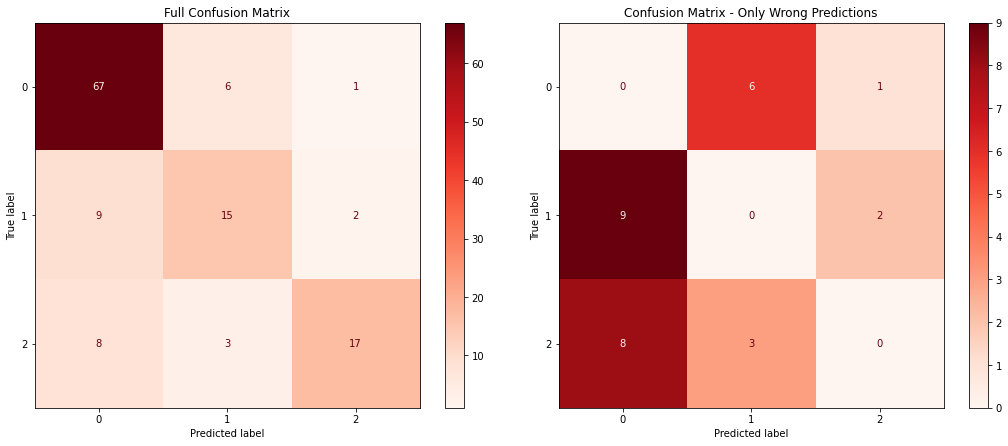

In [ ]:
mnet_balanced_pose_acc = accuracy_score(pose_test.pose, pred_labels_mnet_balanced)
mnet_balanced_pose_f1 = f1_score(pose_test.pose,
                                 pred_labels_mnet_balanced,
                                 average='macro',
                                 zero_division=0)

print('Accuracy:', mnet_balanced_pose_acc)
print('F1-score:', mnet_balanced_pose_f1, "\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

mnet_balanced_pose_martix = confusion_matrix(pose_test.pose, pred_labels_mnet_balanced)
ConfusionMatrixDisplay(mnet_balanced_pose_martix).plot(ax=axes[0], cmap='Reds')
axes[0].title.set_text('Full Confusion Matrix')

np.fill_diagonal(mnet_balanced_pose_martix, 0)
ConfusionMatrixDisplay(mnet_balanced_pose_martix).plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Confusion Matrix - Only Wrong Predictions')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(pose_test.pose,
                            pred_labels_mnet_balanced,
                            target_names=pose_labels.values(),
                            zero_division=0))

              precision    recall  f1-score   support

       lying       0.80      0.91      0.85        74
         sit       0.62      0.58      0.60        26
       stand       0.85      0.61      0.71        28

    accuracy                           0.77       128
   macro avg       0.76      0.70      0.72       128
weighted avg       0.77      0.77      0.77       128



## Mask-RCNN

Since our model needed to see the images anyway and we annotated the poses ourselves anyway, we decided to drop the keypoints idea and find a different approach for dimension reduction.

Mask R-CNN is a Convolutional Neural Network (CNN) and state-of-the-art in terms of image segmentation. This variant of a Deep Neural Network detects objects in an image and generates a high-quality segmentation mask for each instance.

We wanted to use the Mask-RCNN abilities to detect the cats in our images and cut the background and other irrelevant objects, in order to reduce the dimension of our problem.

We were hoping this approach would get better results in classifying the position of the cat.

As with the keypoints, we needed to customize the masking functions (https://github.com/tensorflow/tpu/tree/master/models/official/mask_rcnn) and make the changes permanent, so we copied the needed functions directly to our notebook and changed what we needed.

The following is the COCO dataset index mapping, to work together with the COCO Mask-RCNN functions:

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

We needed functions that detect only the cat and cut all other details in the image:

In [ ]:
def cut_mask(image, mask):
  """Cuts the mask of the image.

  Args:
    image: uint8 numpy array with shape (img_height, img_height, 3)
    mask: a uint8 numpy array of shape (img_height, img_height) with
      values between either 0 or 1.

  Raises:
    ValueError: On incorrect data type for image or masks.
  """
  mask = mask.astype(np.uint8)
  if image.dtype != np.uint8:
    raise ValueError('`image` not of type np.uint8')
  if mask.dtype != np.uint8:
    raise ValueError('`mask` not of type np.uint8')
  if np.any(np.logical_and(mask != 1, mask != 0)):
    raise ValueError('`mask` elements should be in [0, 1]')
  if image.shape[:2] != mask.shape:
    raise ValueError('The image has spatial dimensions %s but the mask has '
                     'dimensions %s' % (image.shape[:2], mask.shape))

  masked = cv2.bitwise_and(image, image, mask = mask)
  return masked

In [ ]:
def apply_cut_mask(
    image,
    boxes,
    classes,
    scores,
    instance_masks=None,
    max_boxes_to_draw=20,
    min_score_thresh=.5):

  mask = np.zeros(instance_masks[0].shape)
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if classes[i] != 17:
      continue
    if scores is None or scores[i] > min_score_thresh:
      mask = np.logical_or(mask, instance_masks[i])

  if np.any(mask):
    image = cut_mask(image, mask)

  return image

Finally, the masking_cats function gets the original Dataframe and updates it with the masked images:

In [ ]:
def masking_cats(df):
  session = tf.compat.v1.Session(graph=tf.Graph())
  saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
  _ = tf.compat.v1.saved_model.load(session, ['serve'], saved_model_dir)
  paths = []
  for i in df.index:
    image_path = df.image_path[i]
    with open(image_path, 'rb') as f:
      np_image_string = np.array([f.read()])

    image = PIL.Image.open(image_path)
    width, height = image.size
    np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

    num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
        ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
        feed_dict={'Placeholder:0': np_image_string})

    num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
    detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
    detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
    detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
    instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
    ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
    processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
    segmentations = generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

    max_boxes_to_draw = 50
    min_score_thresh = 0.5

    image_with_detections = apply_cut_mask(
        np_image,
        detection_boxes,
        detection_classes,
        detection_scores,
        instance_masks=segmentations,
        max_boxes_to_draw=max_boxes_to_draw,
        min_score_thresh=min_score_thresh)
    output_image_path = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/masked_images/' + str(i) + '.jpg'
    PIL.Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
    paths.append(output_image_path)

  df['masked_path'] = paths

Let's create the new dataframe, shuffle and save it:

(No need to run, file already exists)

In [ ]:
# masking_cats(df_poses)
# df_poses = (df_poses.sample(frac=1, random_state=seed).reset_index(drop=True))
# df_poses.to_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/masked_poses.csv')

In [ ]:
masked_poses = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/keypoints/annotations/masked_poses.csv', index_col=0)
masked_poses

,image_path,pose,masked_path
0,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
1,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
3,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
4,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
...,...,...,...
1018,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
1019,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
1020,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
1021,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit,/content/drive/MyDrive/Colab Notebooks/FINAL_P...


In [ ]:
new_paths = []
# first_part = 'petfinder/images'
for i in df_petfinder.index:
  new_paths.append(df_petfinder.Filepath[i][81:])

df_petfinder = pd.DataFrame(zip(new_paths, df_petfinder.Labels), columns=['Filepath', 'Labels'])
df_petfinder

,image_path,pose,masked_path
0,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
1,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
3,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
4,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
...,...,...,...
1018,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
1019,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
1020,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,lying,/content/drive/MyDrive/Colab Notebooks/FINAL_P...
1021,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,sit,/content/drive/MyDrive/Colab Notebooks/FINAL_P...


Displaying the first 12 masked images, as an example:

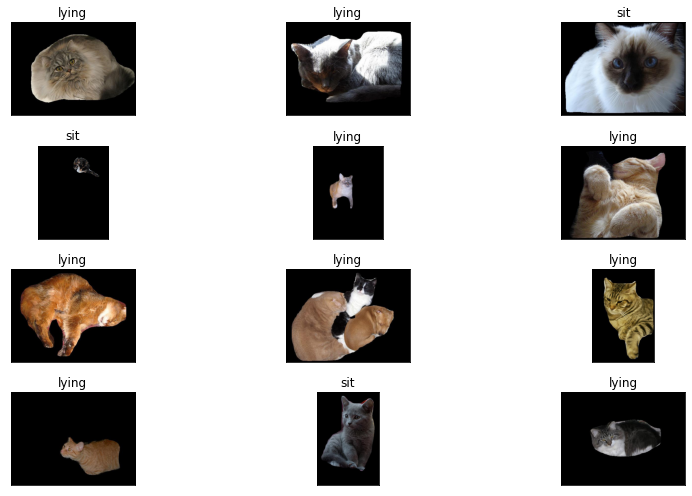

In [ ]:
f, a = plt.subplots(nrows=4, ncols=3, figsize=(13, 7),
                    subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(masked_poses.masked_path[i]))
    ax.set_title(masked_poses.pose[i])

plt.tight_layout()
plt.show()

## MRCNN Model

### Preprocessing

In [ ]:
masked_train, masked_test = train_test_split(masked_poses,
                                             test_size = test_ratio,
                                             random_state=seed,
                                             shuffle=False)

masked_val, masked_test = train_test_split(masked_test,
                                           test_size=test_ratio/(test_ratio + validation_ratio),
                                           random_state=seed,
                                           shuffle=False)

Data generation:

In [ ]:
masked_x_train = img_datagen.flow_from_dataframe(dataframe=masked_train,
                                                 x_col='masked_path',
                                                 y_col='pose',
                                                 target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 seed=seed)

masked_x_val = img_datagen.flow_from_dataframe(dataframe=masked_val,
                                               x_col='masked_path',
                                               y_col='pose',
                                               target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                               shuffle=False,
                                               batch_size=BATCH_SIZE,
                                               seed=seed)

masked_x_test = img_datagen.flow_from_dataframe(dataframe=masked_test,
                                                x_col='masked_path',
                                                y_col='pose',
                                                target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                seed=seed)

Found 767 validated image filenames belonging to 3 classes.
Found 128 validated image filenames belonging to 3 classes.
Found 128 validated image filenames belonging to 3 classes.


In [ ]:
masked_labels = dict([(value, key) for key, value in masked_x_train.class_indices.items()])
masked_labels

{0: 'lying', 1: 'sit', 2: 'stand'}

### Model Creation

In [ ]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=IMAGE_DIMS)
mnet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
mnet_masked_pose = create_model(mnet, classes=3, name='mnet_masked_pose')
mnet_masked_pose.summary()

Model: "mnet_masked_pose"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 771       
                                                                 
Total params: 2,586,691
Trainable params: 328,707


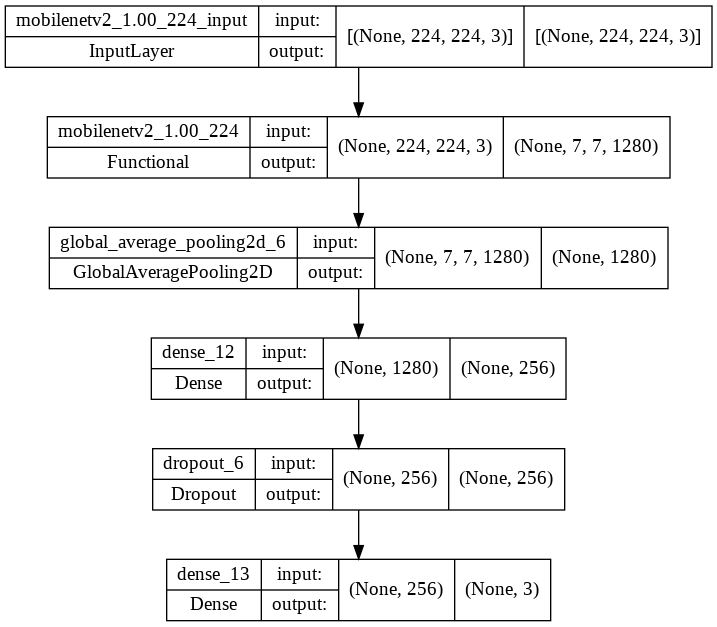

In [ ]:
plot_model(mnet_masked_pose,
           to_file='/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_masked_pose/mnet_masked_pose_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
checkpoint_mnet_masked_filepath = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_masked_pose/checkpoint_mnet_masked'

In [ ]:
checkpoint_mnet_masked_callback = ModelCheckpoint(filepath=checkpoint_mnet_masked_filepath,
                                                  save_weights_only=True,
                                                  monitor='val_accuracy',
                                                  mode='max',
                                                  save_best_only=True)

### Model Training

In [ ]:
history_mnet_masked_pose = mnet_masked_pose.fit(masked_x_train,
                                                validation_data=masked_x_val,
                                                callbacks=[checkpoint_mnet_masked_callback],
                                                steps_per_epoch=len(masked_train)/BATCH_SIZE,
                                                validation_steps=len(masked_val)/BATCH_SIZE,
                                                epochs=EPOCHS,
                                                verbose=1)

Epoch 1/15
76/76 [==============================] - 228s 3s/step - loss: 9.8176 - accuracy: 0.5306 - val_loss: 9.3607 - val_accuracy: 0.6562
Epoch 2/15
76/76 [==============================] - 14s 177ms/step - loss: 9.1744 - accuracy: 0.6154 - val_loss: 8.9042 - val_accuracy: 0.6016
Epoch 3/15
76/76 [==============================] - 15s 192ms/step - loss: 8.6443 - accuracy: 0.6597 - val_loss: 8.4372 - val_accuracy: 0.6562
Epoch 4/15
76/76 [==============================] - 13s 175ms/step - loss: 8.2079 - accuracy: 0.6701 - val_loss: 8.0350 - val_accuracy: 0.6406
Epoch 5/15
76/76 [==============================] - 14s 176ms/step - loss: 7.7521 - accuracy: 0.7119 - val_loss: 7.6278 - val_accuracy: 0.7109
Epoch 6/15
76/76 [==============================] - 13s 175ms/step - loss: 7.3607 - accuracy: 0.6949 - val_loss: 7.2257 - val_accuracy: 0.6719
Epoch 7/15
76/76 [==============================] - 13s 175ms/step - loss: 7.0239 - accuracy: 0.7093 - val_loss: 6.9609 - val_accuracy: 0.6484
E

In [ ]:
history_mnet_masked_pose = mnet_masked_pose.fit(masked_x_train,
                                                validation_data=masked_x_val,
                                                callbacks=[checkpoint_mnet_masked_callback],
                                                steps_per_epoch=len(masked_train)/BATCH_SIZE,
                                                validation_steps=len(masked_val)/BATCH_SIZE,
                                                epochs=EPOCHS,
                                                verbose=1)

Epoch 1/15
76/76 [==============================] - 313s 4s/step - loss: 9.7638 - accuracy: 0.5658 - val_loss: 9.2950 - val_accuracy: 0.6484
Epoch 2/15
76/76 [==============================] - 14s 185ms/step - loss: 9.1214 - accuracy: 0.6402 - val_loss: 8.8473 - val_accuracy: 0.6484
Epoch 3/15
76/76 [==============================] - 14s 176ms/step - loss: 8.6106 - accuracy: 0.6558 - val_loss: 8.4130 - val_accuracy: 0.6484
Epoch 4/15
76/76 [==============================] - 13s 176ms/step - loss: 8.1671 - accuracy: 0.6806 - val_loss: 7.9942 - val_accuracy: 0.6484
Epoch 5/15
76/76 [==============================] - 14s 178ms/step - loss: 7.7582 - accuracy: 0.7066 - val_loss: 7.6285 - val_accuracy: 0.6875
Epoch 6/15
76/76 [==============================] - 14s 177ms/step - loss: 7.3664 - accuracy: 0.7093 - val_loss: 7.1993 - val_accuracy: 0.6797
Epoch 7/15
76/76 [==============================] - 14s 179ms/step - loss: 6.9962 - accuracy: 0.7145 - val_loss: 6.8966 - val_accuracy: 0.7031
E

In [ ]:
history_mnet_masked_pose = mnet_masked_pose.fit(masked_x_train,
                                                validation_data=masked_x_val,
                                                callbacks=[checkpoint_mnet_masked_callback],
                                                steps_per_epoch=len(masked_train)/BATCH_SIZE,
                                                validation_steps=len(masked_val)/BATCH_SIZE,
                                                epochs=EPOCHS,
                                                verbose=1)

Epoch 1/15
76/76 [==============================] - 730s 10s/step - loss: 9.7838 - accuracy: 0.5463 - val_loss: 9.3622 - val_accuracy: 0.6172
Epoch 2/15
76/76 [==============================] - 14s 180ms/step - loss: 9.1452 - accuracy: 0.6180 - val_loss: 8.8353 - val_accuracy: 0.6406
Epoch 3/15
76/76 [==============================] - 14s 180ms/step - loss: 8.6463 - accuracy: 0.6532 - val_loss: 8.3218 - val_accuracy: 0.7031
Epoch 4/15
76/76 [==============================] - 14s 178ms/step - loss: 8.2346 - accuracy: 0.6493 - val_loss: 7.9537 - val_accuracy: 0.6328
Epoch 5/15
76/76 [==============================] - 14s 180ms/step - loss: 7.7606 - accuracy: 0.6988 - val_loss: 7.5032 - val_accuracy: 0.7344
Epoch 6/15
76/76 [==============================] - 14s 176ms/step - loss: 7.4205 - accuracy: 0.6806 - val_loss: 7.1786 - val_accuracy: 0.7188
Epoch 7/15
76/76 [==============================] - 13s 175ms/step - loss: 7.0177 - accuracy: 0.7158 - val_loss: 6.8210 - val_accuracy: 0.7109


In [ ]:
_ = mnet_masked_pose.load_weights(checkpoint_mnet_masked_filepath)

In [ ]:
save_model(mnet_masked_pose, '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_masked_pose/mnet_masked_pose_model')

### Model Application

In [ ]:
mnet_masked_pose = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_masked_pose/mnet_masked_pose_model')

In [ ]:
predictions_mnet_masked = mnet_masked_pose.predict(masked_x_test)
predictions_mnet_masked = np.argmax(predictions_mnet_masked, axis=1)
predictions_mnet_masked

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
pred_labels_mnet_masked = np.vectorize(masked_labels.get)(predictions_mnet_masked)
pred_labels_mnet_masked

array(['lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying', 'lying', 'sit', 'lying', 'lying',
       'lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'sit', 'lying', 'lying', 'lying', 'lying',
       'lying', 'sit', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'sit', 'sit',
       'sit', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'lying', 'sit', 'lying', 'lying', 'sit', 'lying', 'lying', 'lying',
       'lying', 'lying', 'lying', 'lying', 'lying', 'sit', 'lying',
       'lying', 'lying', 'lying', 'lying', 'lying', 'sit', 'lying',
       'lying', 'lying', 'stand', 'sit', 'lying', 'sit', 'stand', 'lying',
       'lying', 'lying', 'lying', 'lying', 'lying', 'sit', 'lying',
       'lying', 'lying', 'lying', 'lying', 'lying', 'lying', 'lying',
       'sit', 'lying', 'lying', 'lying', 'sit', 'lying', 'lying', 'sit',
       'lying', 

### Model Evaluation

Accuracy: 0.71875
F1-score: 0.48327359617682203 



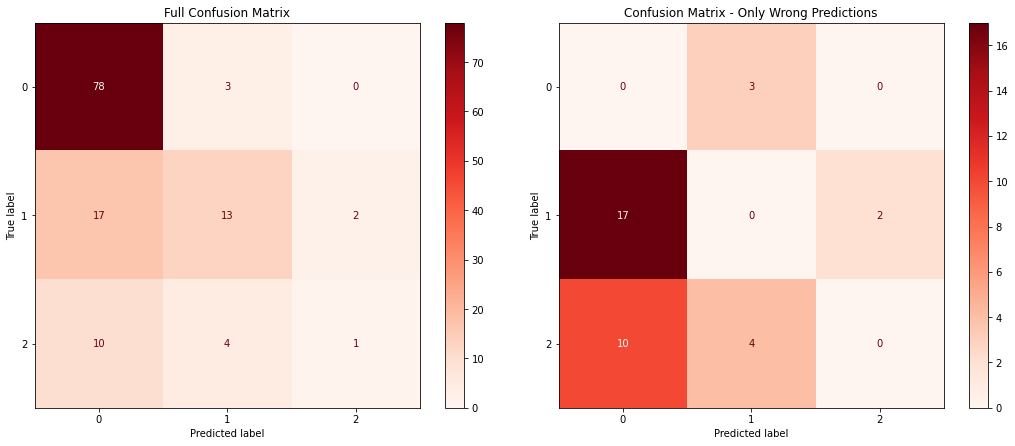

In [ ]:
mnet_masked_pose_acc = accuracy_score(masked_test.pose, pred_labels_mnet_masked)
mnet_masked_pose_f1 = f1_score(masked_test.pose,
                               pred_labels_mnet_masked,
                               average='macro',
                               zero_division=0)

print('Accuracy:', mnet_masked_pose_acc)
print('F1-score:', mnet_masked_pose_f1, "\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

mnet_masked_pose_martix = confusion_matrix(masked_test.pose, pred_labels_mnet_masked)
ConfusionMatrixDisplay(mnet_masked_pose_martix).plot(ax=axes[0], cmap='Reds')
axes[0].title.set_text('Full Confusion Matrix')

np.fill_diagonal(mnet_masked_pose_martix, 0)
ConfusionMatrixDisplay(mnet_masked_pose_martix).plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Confusion Matrix - Only Wrong Predictions')

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(masked_test.pose,
                            pred_labels_mnet_masked,
                            target_names=masked_labels.values(),
                            zero_division=0))

              precision    recall  f1-score   support

       lying       0.74      0.96      0.84        81
         sit       0.65      0.41      0.50        32
       stand       0.33      0.07      0.11        15

    accuracy                           0.72       128
   macro avg       0.58      0.48      0.48       128
weighted avg       0.67      0.72      0.67       128



# Combined Model

Now we can combine the two tasks of this project, classifying breeds and classifying poses, using two different approaches, and compare them:

1. "Chained" Model
2. Unified Model

## "Chained" Model

The first approach connects the two previously created models one after the other, like a chain.

Using the weights we saved separately for each model, we create a function that receives new images and outputs 2 results - the breed and the pose.


In [ ]:
breeds_label = {0: 'Abyssinian',
                1: 'Bengal',
                2: 'Birman',
                3: 'Bombay',
                4: 'British Shorthair',
                5: 'Egyptian Mau',
                6: 'Maine Coon',
                7: 'Persian',
                8: 'Ragdoll',
                9: 'Russian Blue',
                10: 'Siamese',
                11: 'Sphynx'}

poses_label = {0: 'lying', 1: 'sit', 2: 'stand'}

In [ ]:
def predict_model(model, images, labels):
    resize = tf.image.resize(images, [IMAGE_DIMS[0], IMAGE_DIMS[1]])
    resize = np.expand_dims(resize, axis=0)
    prediction1 = model.predict(resize)
    prediction = np.argmax(prediction1, axis=1)
    pred_labels = np.vectorize(labels.get)(prediction)
    print(pred_labels[0], round(100*max(prediction1[0]), 1))
    return pred_labels[0], round(100*max(prediction1[0]), 1)

We used the MRCNN visualize function ("visualize_boxes_and_labels_on_image_array" from /tpu/models/official/mask_rcnn/object_detection/visualization_utils.py) and altered it to mask the cat and present the masking and predictions in the test image, for easy visualization:

In [ ]:
def altered_visualize_boxes_and_labels_on_image_array(
    image,
    boxes,
    classes,
    scores,
    category_index,
    pred_label1="",
    pred1=0,
    pred_label2="",
    pred2=0,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=1,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    groundtruth_box_visualization_color='black',
    skip_scores=False,
    skip_labels=False):
  """Overlay labeled boxes on an image with formatted scores and label names.
  This function groups boxes that correspond to the same location
  and creates a display string for each detection and overlays these
  on the image. Note that this function modifies the image in place, and returns
  that same image.
  Args:
    image: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    instance_masks: a numpy array of shape [N, image_height, image_width] with
      values ranging between 0 and 1, can be None.
    instance_boundaries: a numpy array of shape [N, image_height, image_width]
      with values ranging between 0 and 1, can be None.
    keypoints: a numpy array of shape [N, num_keypoints, 2], can
      be None
    use_normalized_coordinates: whether boxes is to be interpreted as
      normalized coordinates or not.
    max_boxes_to_draw: maximum number of boxes to visualize.  If None, draw
      all boxes.
    min_score_thresh: minimum score threshold for a box to be visualized
    agnostic_mode: boolean (default: False) controlling whether to evaluate in
      class-agnostic mode or not.  This mode will display scores but ignore
      classes.
    line_thickness: integer (default: 4) controlling line width of the boxes.
    groundtruth_box_visualization_color: box color for visualizing groundtruth
      boxes
    skip_scores: whether to skip score when drawing a single detection
    skip_labels: whether to skip label when drawing a single detection
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3) with overlaid boxes.
  """
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_instance_boundaries_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if classes[i] != 17:
      continue
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in category_index.keys():
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(int(100*scores[i]))
          else:
            display_str = '{}: {}% ,{}: {}%'.format(pred_label1, pred1, pred_label2, pred2)
        box_to_display_str_map[box].append(display_str)
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Draw all boxes onto image.
  for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box
    if instance_masks is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_masks_map[box],
          color=color
      )
    if instance_boundaries is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_boundaries_map[box],
          color='red',
          alpha=1.0
      )
    draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)
    if keypoints is not None:
      draw_keypoints_on_image_array(
          image,
          box_to_keypoints_map[box],
          color=color,
          radius=line_thickness / 2,
          use_normalized_coordinates=use_normalized_coordinates)

  return image

Finally, the chained prediction function loads the two models, makes a prediction on one image and presents it:

In [ ]:
def make_chained_prediction(image, breeds_label, poses_label):
  session = tf.compat.v1.Session(graph=tf.Graph())
  image1 = cv2.imread(image)
  saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
  _ = tf.compat.v1.saved_model.load(session, ['serve'], saved_model_dir)
  breed_model = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_batogov/mnet_batogov_model', compile=True)
  pose_model = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/mnet_balanced_pose/mnet_balanced_pose_model', compile=True)
  with open(image, 'rb') as f:
    np_image_string = np.array([f.read()])
  image = PIL.Image.open(image)
  width, height = image.size
  np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
  num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})
  num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
  instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)
  max_boxes_to_draw = 1
  min_score_thresh = 0.5
  pred_label1, pred1 = predict_model(breed_model, image1, breeds_label)
  pred_label2, pred2 = predict_model(pose_model, apply_cut_mask(
        np_image,
        detection_boxes,
        detection_classes,
        detection_scores,
        instance_masks=segmentations,
        max_boxes_to_draw=max_boxes_to_draw,
        min_score_thresh=min_score_thresh),poses_label)
  image_with_detections = altered_visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    pred_label1,
    pred1,
    pred_label2,
    pred2,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
  output_image_path = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/Other/chained_test.jpg'
  PIL.Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
  display(Image(output_image_path, width=1024))

Let's run an example.

We'll test it on the following image of a sitting Ragdoll cat, not from any of our datasets:

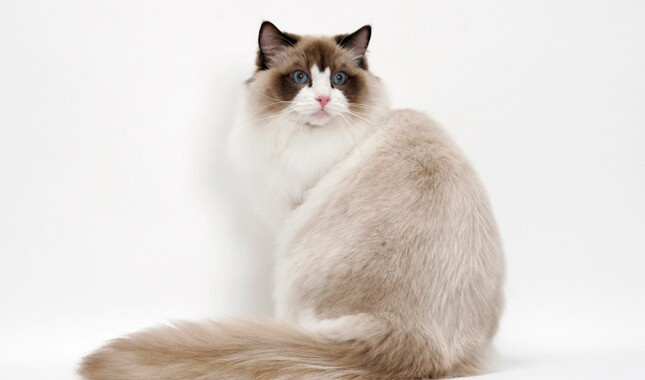

In [ ]:
test_path = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/Other/test_image.jpg'
test_image = Image(test_path)
display(test_image)

Ragdoll 23.8


sit 54.5


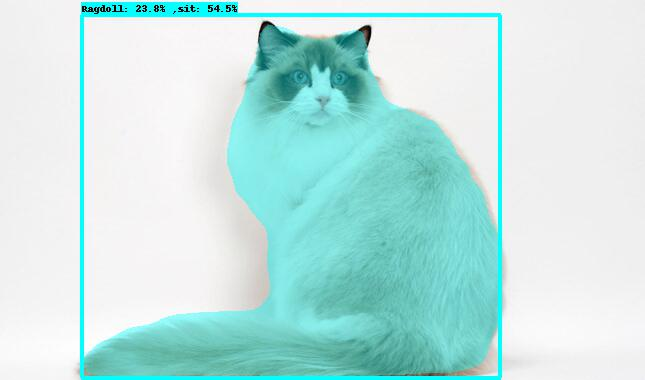

In [ ]:
make_chained_prediction(test_path, breeds_label, poses_label)

Because we used previously created models, we already have the evaluation of them for the final comparison.

## Unified Model

The second approach requires creating a new model, and training it to classify both the breed and the pose of the cat in the image.

In order to do that, we needed a combined dataset with two labels for each image - breed and pose.

We chose the blanaced breed dataset - the Batogov dataset - and annotated it the same way we did for the keypoints dataset.

### Annotations

Once again, photos we were unable to determine the pose for them were skipped.

In [ ]:
# annotations_bat = annotate(list(df_batogov.index),
#                           options=['sit', 'stand', 'lying'],
#                           display_fn=lambda filename: display(Image(filename))
#                           )

Creating a combined dataframe:

In [ ]:
# poses = []
# breeds = []
# paths = []

# for i in annotations:
#   poses.append(i[1])
#   breeds.append(df_batogov.Breed[i[0]])
#   paths.append(df_batogov.Filepath[i[0]])

# batogov_combined = pd.DataFrame(zip(paths, breeds, poses), columns=['Filepath', 'Breed', 'Pose'])
# batogov_combined

Shuffling and saving as a csv file (no need to run again):

In [ ]:
# batogov_combined = (batogov_combined.sample(frac=1, random_state=seed).reset_index(drop=True))
# batogov_combined

In [ ]:
# batogov_combined.to_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/batogov_combined.csv')

In [ ]:
batogov_combined = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/batogov_combined.csv', index_col=0)
batogov_combined

,Filepath,Breed,Pose
0,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Abyssinian,sit
1,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Birman,lying
2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Siamese,sit
3,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Maine Coon,sit
4,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Bengal,lying
...,...,...,...
1405,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Maine Coon,sit
1406,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Persian,sit
1407,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Russian Blue,sit
1408,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,Birman,sit


### EDA

Let's check the distributions.

After dropping some images in the annotating process, the nearly perfect ditribution of the breeds in the Batogov dataset was only slightly reduced in quality:

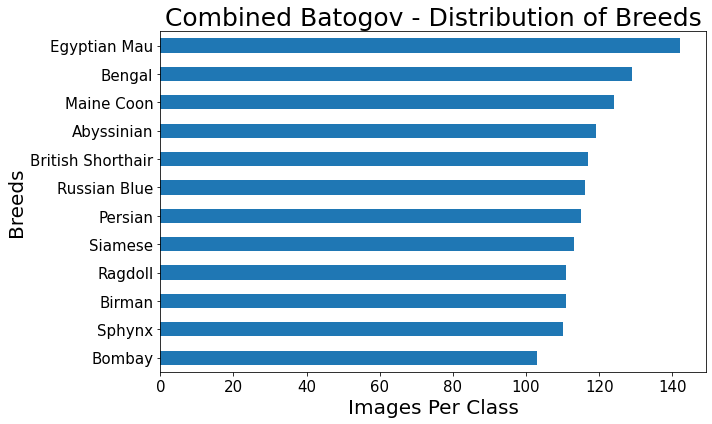

In [ ]:
ax = pd.value_counts(batogov_combined['Breed'], ascending=True).plot(kind='barh',
                                                                     fontsize="15",
                                                                     title="Combined Batogov - Distribution of Breeds",
                                                                     figsize=(10, 6))
ax.set(xlabel="Images Per Class", ylabel="Breeds")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(25)
plt.tight_layout()
plt.show()

In [ ]:
batogov_combined.Breed.value_counts()

Egyptian Mau         142
Bengal               129
Maine Coon           124
Abyssinian           119
British Shorthair    117
Russian Blue         116
Persian              115
Siamese              113
Birman               111
Ragdoll              111
Sphynx               110
Bombay               103
Name: Breed, dtype: int64

The poses, however, are highly imbalanced, similarly to the Keypoints dataset. Although, interestingly, the leading label is different ("lying" vs "sit").

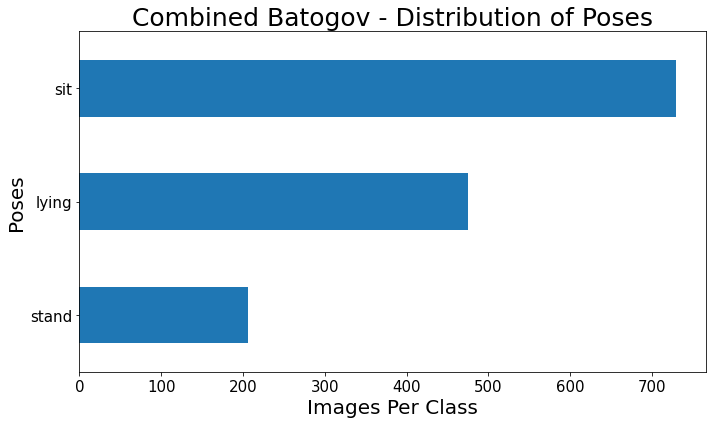

In [ ]:
ax = pd.value_counts(batogov_combined['Pose'], ascending=True).plot(kind='barh',
                                                                    fontsize="15",
                                                                    title="Combined Batogov - Distribution of Poses",
                                                                    figsize=(10, 6))
ax.set(xlabel="Images Per Class", ylabel="Poses")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(25)
plt.tight_layout()
plt.show()

In [ ]:
batogov_combined.Pose.value_counts()

sit      729
lying    475
stand    206
Name: Pose, dtype: int64

### Preprocessing

In [ ]:
breedLE = LabelEncoder()
poseLE = LabelEncoder()
breedLabels = breedLE.fit_transform(batogov_combined['Breed'])
poseLabels = poseLE.fit_transform(batogov_combined['Pose'])
batogov_com = pd.DataFrame(zip(batogov_combined.Filepath, breedLabels, poseLabels), columns=['Filepath', 'Breed', 'Pose'])
batogov_com

,Filepath,Breed,Pose
0,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,0,1
1,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,2,0
2,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,10,1
3,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,6,1
4,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,1,0
...,...,...,...
1405,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,6,1
1406,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,7,1
1407,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,9,1
1408,/content/drive/MyDrive/Colab Notebooks/FINAL_P...,2,1


Train/Test split:

This time we need to split the dataset into two different y columns, for the two labels.

(Shuffle=False because we shuffled the dataframe previously, and we need it to match the saved arrays for later)

In [ ]:
x_train, x_test, y_train_breed, y_test_breed, y_train_pose, y_test_pose = train_test_split(batogov_com.Filepath, batogov_com.Breed, batogov_com.Pose, test_size=test_ratio, random_state=seed, shuffle=False)
x_val, x_test, y_val_breed, y_test_breed, y_val_pose, y_test_pose = train_test_split(x_test, y_test_breed, y_test_pose, test_size=test_ratio/(test_ratio+validation_ratio), random_state=seed, shuffle=False)

Instead of the normal data generation which includes preprocessing, we included preprocessing layers in the model, so we could feed the images into the two branches of the model more easily.

Here, we're loading the images prior to the training, with a custom created "image data generator", which isn't a generator at all:

In [ ]:
def load_im(paths):
    x = []
    for filename in paths:
        raw = tf.io.read_file(filename)
        image = tf.image.decode_image(raw, channels=3)
        image = tf.image.resize_with_pad(image, IMAGE_DIMS[1], IMAGE_DIMS[0])
        image = image.numpy()
        x.append(image)

    return np.array(x)

# x_train = load_im(x_train)
# x_val = load_im(x_val)
# x_test = load_im(x_test)

In [ ]:
# np.save('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/unified_x_train.npy', x_train)
# np.save('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/unified_x_val.npy', x_val)
# np.save('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/unified_x_test.npy', x_test)

In [ ]:
x_train = np.load('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/unified_x_train.npy')
x_val = np.load('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/unified_x_val.npy')
x_test = np.load('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/batogov/annotations/unified_x_test.npy')

### Model Creation

The unified model is actually one model that we split into two branches. We made two functions to create each branch, and a function to create the unified model.

In [ ]:
def build_breed_branch(inputs):
    mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                          include_top=False,
                                                          input_shape=IMAGE_DIMS)
    mnet._name = 'mnet_breed'
    mnet.trainable = False
    model = mnet(inputs)
    model = GlobalAveragePooling2D()(model)
    model = Dense(256, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.l2(0.0175))(model)
    model = Dropout(0.5, seed=seed)(model)
    model = Dense(12, activation='softmax', name='breed_output')(model)

    return model

In [ ]:
def build_pose_branch(inputs):
    mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                          include_top=False,
                                                          input_shape=IMAGE_DIMS)
    mnet._name = 'mnet_pose'
    mnet.trainable = False
    model = mnet(inputs)
    model = GlobalAveragePooling2D()(model)
    model = Dense(256, activation='relu', kernel_initializer='he_uniform',
                  kernel_regularizer=regularizers.l2(0.0175))(model)
    model = Dropout(0.5, seed=seed)(model)
    model = Dense(3, activation='softmax', name='pose_output')(model)

    return model

In [ ]:
def build():
    inputShape = IMAGE_DIMS
    inputs = Input(shape=inputShape)

    preprocess = tf.keras.layers.RandomRotation(0.3, seed=seed)(inputs)
    preprocess = tf.keras.layers.RandomWidth(0.2, seed=seed)(preprocess)
    preprocess = tf.keras.layers.RandomHeight(0.2, seed=seed)(preprocess)
    preprocessed = tf.keras.layers.RandomFlip('horizontal', seed=seed)(preprocess)

    breedBranch = build_breed_branch(preprocessed)
    poseBranch = build_pose_branch(preprocessed)

    model = Model(inputs=preprocessed,
                  outputs=(breedBranch, poseBranch),
                  name="catnet")

    return model

In [ ]:
catnet = build()

losses = {"breed_output": 'sparse_categorical_crossentropy',
          "pose_output": 'sparse_categorical_crossentropy'}

lossWeights = {"breed_output": 1.0,
               "pose_output": 1.0}

metrics = {"breed_output": 'sparse_categorical_accuracy',
           "pose_output": 'sparse_categorical_accuracy'}

print("[INFO] compiling model...")
catnet.compile(loss=losses, optimizer=SGD(), loss_weights=lossWeights, metrics=metrics, run_eagerly=True)
print('Done.')

9420800/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
Done.


In [ ]:
catnet.summary()

Model: "catnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 mnet_breed (Functional)        (None, 7, 7, 1280)   2257984     ['input_4[0][0]']                
                                                                                                  
 mnet_pose (Functional)         (None, 7, 7, 1280)   2257984     ['input_4[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['mnet_breed[1][0]']        

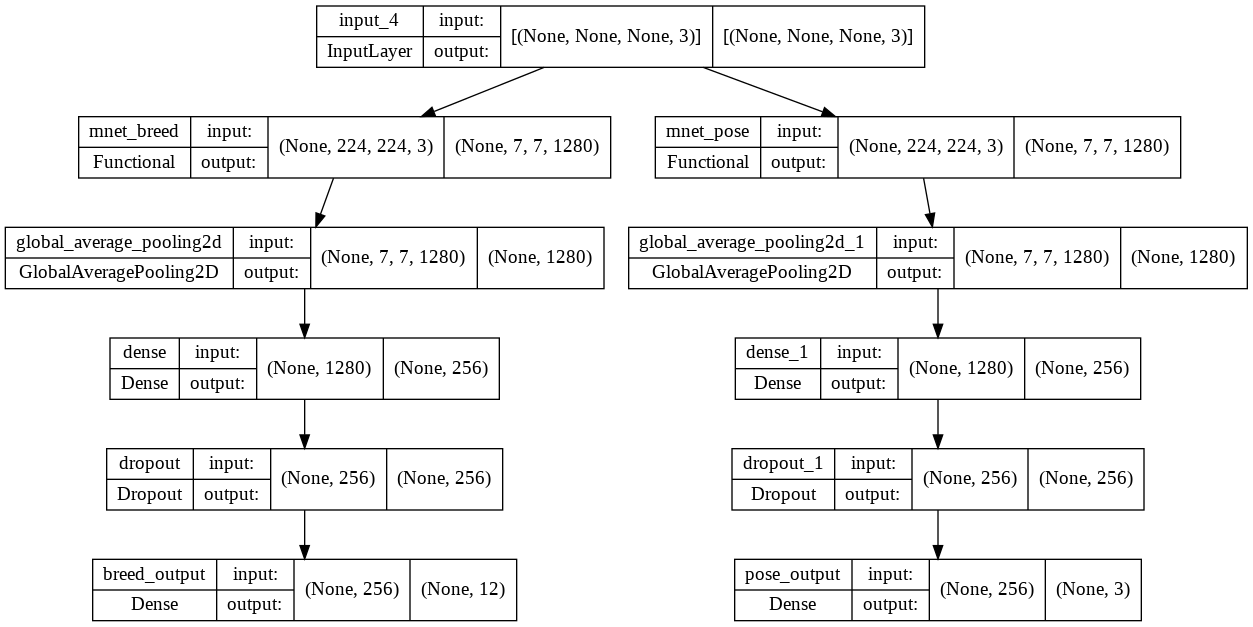

In [ ]:
plot_model(catnet,
           to_file='/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/catnet/catnet_plot.png',
           show_shapes=True,
           show_layer_names=True)

The callback can't monitor two values at once, so we changed save_best_only to False, so it'll save all weights and we could choose the best one on our own.

In [ ]:
checkpoint_catnet_filepath = '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/catnet/checkpoint_catnet_weights-{epoch:02d}.hdf5'

In [ ]:
checkpoint_catnet_callback = ModelCheckpoint(filepath=checkpoint_catnet_filepath,
                                             save_weights_only=True,
                                             mode='max',
                                             save_best_only=False)

### Model Training

In [ ]:
history_catnet = catnet.fit(x=x_train,
                            y={'breed_output': y_train_breed, 'pose_output': y_train_pose},
                            validation_data=(x_val, {'breed_output': y_val_breed, 'pose_output': y_val_pose}),
                            callbacks=[checkpoint_catnet_callback],
                            steps_per_epoch=len(x_train)/BATCH_SIZE,
                            validation_steps=len(x_val)/BATCH_SIZE,
                            epochs=EPOCHS,
                            verbose=1)

Epoch 1/15
105/105 [==============================] - 43s 294ms/step - loss: 21.0754 - breed_output_loss: 2.6455 - pose_output_loss: 1.1509 - breed_output_sparse_categorical_accuracy: 0.1069 - pose_output_sparse_categorical_accuracy: 0.5090 - val_loss: 20.0740 - val_breed_output_loss: 2.4362 - val_pose_output_loss: 0.9985 - val_breed_output_sparse_categorical_accuracy: 0.1250 - val_pose_output_sparse_categorical_accuracy: 0.4773
Epoch 2/15
105/105 [==============================] - 31s 291ms/step - loss: 19.3804 - breed_output_loss: 2.4351 - pose_output_loss: 0.8976 - breed_output_sparse_categorical_accuracy: 0.1343 - pose_output_sparse_categorical_accuracy: 0.5979 - val_loss: 18.8139 - val_breed_output_loss: 2.4013 - val_pose_output_loss: 0.9561 - val_breed_output_sparse_categorical_accuracy: 0.1420 - val_pose_output_sparse_categorical_accuracy: 0.5511
Epoch 3/15
105/105 [==============================] - 33s 309ms/step - loss: 18.1561 - breed_output_loss: 2.3522 - pose_output_loss: 0

In [ ]:
val_breed_acc = history_catnet.history['val_breed_output_sparse_categorical_accuracy']
val_pose_acc = history_catnet.history['val_pose_output_sparse_categorical_accuracy']

In [ ]:
accs = [(val_breed_acc[i]+val_pose_acc[i])*0.5 for i in range(len(val_breed_acc))]
accs

[0.3011363595724106,
 0.34659091383218765,
 0.40909090638160706,
 0.3892045319080353,
 0.42897727340459824,
 0.4062500149011612,
 0.4062500074505806,
 0.4005681797862053,
 0.4119318202137947,
 0.43465908616781235,
 0.44034090638160706,
 0.38352273404598236,
 0.3863636404275894,
 0.40625,
 0.4261363670229912]

In [ ]:
best_checkpoint_catnet_filepath = f'/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/catnet/checkpoint_catnet_weights-{accs.index(max(accs)):02d}.hdf5'

In [ ]:
_ = catnet.load_weights(best_checkpoint_catnet_filepath)

In [ ]:
save_model(catnet, '/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/catnet/catnet_model')

### Model Application

In [ ]:
catnet = load_model('/content/drive/MyDrive/Colab Notebooks/FINAL_PROJECT_HILA_KATZ_AND_AYELET_ZUCKER/models/catnet/catnet_model')

In [ ]:
predictions_catnet = catnet.predict(x_test)
predictions_catnet = (np.argmax(predictions_catnet[0], axis=1), np.argmax(predictions_catnet[1], axis=1))
predictions_catnet

(array([11,  6,  1,  4,  4,  4,  1, 11,  9,  6,  1,  2, 10, 11, 10,  1,  2,
         5, 10,  3, 11,  2,  1,  9,  5,  2, 11, 11,  7,  7,  4, 11,  4,  2,
         1, 10,  1,  1, 11, 11,  9,  7,  2,  2,  5,  2,  2,  7, 11,  5, 11,
         6,  2,  5,  4,  7,  2,  4, 11,  5,  4, 11,  1,  2,  5,  7,  1, 10,
         4,  4,  0,  4,  2, 10,  5,  2,  5,  6,  7,  2, 11,  3, 11,  1,  5,
         4,  4,  4,  5,  1,  5,  2,  9,  2, 10,  4,  0,  2,  2,  2,  4, 11,
         1, 11,  7, 10,  1,  5,  1,  0,  2,  1,  5,  0,  2,  2,  2,  1,  1,
         1,  2,  1,  7,  1,  2, 10,  2, 11,  5,  5,  1,  2,  4,  4,  4,  2,
         4,  2,  7,  1,  6,  1,  1,  0,  4,  7,  1, 11,  1,  7,  0, 11,  9,
        10,  9,  1,  2,  1,  4, 11,  6, 11,  2,  2,  6, 11,  3, 10,  2,  2,
         2,  1, 10,  0,  6,  2,  1]),
 array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2

In [ ]:
pred_labels_catnet = (breedLE.inverse_transform(predictions_catnet[0]),
                      poseLE.inverse_transform(predictions_catnet[1]))
pred_labels_catnet

(array(['Sphynx', 'Maine Coon', 'Bengal', 'British Shorthair',
        'British Shorthair', 'British Shorthair', 'Bengal', 'Sphynx',
        'Russian Blue', 'Maine Coon', 'Bengal', 'Birman', 'Siamese',
        'Sphynx', 'Siamese', 'Bengal', 'Birman', 'Egyptian Mau', 'Siamese',
        'Bombay', 'Sphynx', 'Birman', 'Bengal', 'Russian Blue',
        'Egyptian Mau', 'Birman', 'Sphynx', 'Sphynx', 'Persian', 'Persian',
        'British Shorthair', 'Sphynx', 'British Shorthair', 'Birman',
        'Bengal', 'Siamese', 'Bengal', 'Bengal', 'Sphynx', 'Sphynx',
        'Russian Blue', 'Persian', 'Birman', 'Birman', 'Egyptian Mau',
        'Birman', 'Birman', 'Persian', 'Sphynx', 'Egyptian Mau', 'Sphynx',
        'Maine Coon', 'Birman', 'Egyptian Mau', 'British Shorthair',
        'Persian', 'Birman', 'British Shorthair', 'Sphynx', 'Egyptian Mau',
        'British Shorthair', 'Sphynx', 'Bengal', 'Birman', 'Egyptian Mau',
        'Persian', 'Bengal', 'Siamese', 'British Shorthair',
        'British

In [ ]:
real_breed = breedLE.inverse_transform(y_test_breed)
real_pose = poseLE.inverse_transform(y_test_pose)
real_breed, real_pose

(array(['Persian', 'Russian Blue', 'Abyssinian', 'British Shorthair',
        'Abyssinian', 'Siamese', 'British Shorthair', 'Russian Blue',
        'Russian Blue', 'Bombay', 'Persian', 'Siamese', 'Russian Blue',
        'Sphynx', 'Russian Blue', 'Abyssinian', 'British Shorthair',
        'Russian Blue', 'Russian Blue', 'Russian Blue', 'Sphynx',
        'Siamese', 'Bengal', 'Russian Blue', 'Egyptian Mau', 'Maine Coon',
        'Sphynx', 'Persian', 'Maine Coon', 'Ragdoll', 'Egyptian Mau',
        'Maine Coon', 'Maine Coon', 'Ragdoll', 'Abyssinian', 'Siamese',
        'British Shorthair', 'Bombay', 'Egyptian Mau', 'Persian',
        'Russian Blue', 'Abyssinian', 'Birman', 'Bombay', 'Egyptian Mau',
        'Persian', 'Bengal', 'Bengal', 'Birman', 'Bengal', 'Bengal',
        'Russian Blue', 'Russian Blue', 'Egyptian Mau', 'Russian Blue',
        'Ragdoll', 'British Shorthair', 'Abyssinian', 'Sphynx', 'Bombay',
        'Bengal', 'Birman', 'Egyptian Mau', 'Maine Coon', 'Egyptian Mau',
       

### Model Evaluation

Breed accuracy: 0.20903954802259886
Breed f1-score: 0.18257833019430655 

Pose accuracy: 0.655367231638418
Pose f1-score: 0.5358928142273492 



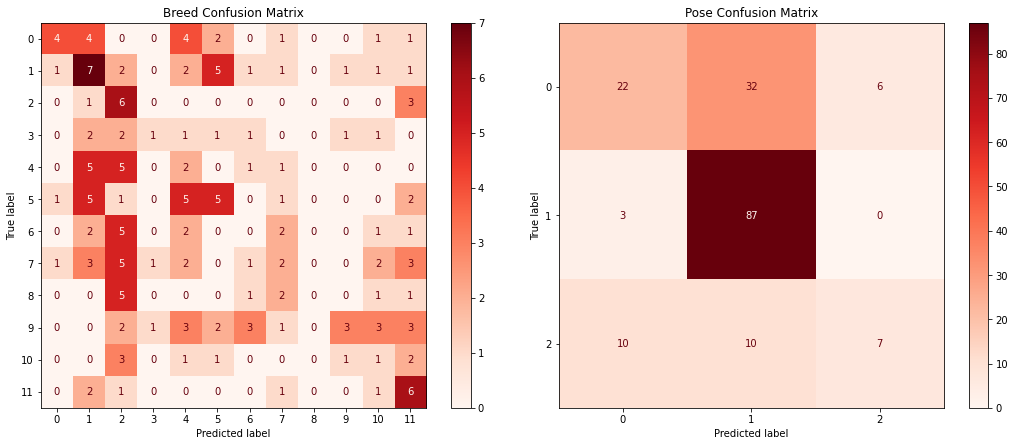

In [ ]:
catnet_breed_acc = accuracy_score(real_breed, pred_labels_catnet[0])
catnet_pose_acc = accuracy_score(real_pose, pred_labels_catnet[1])

catnet_breed_f1 = f1_score(real_breed,
                           pred_labels_catnet[0],
                           average='macro',
                           zero_division=0)
catnet_pose_f1 = f1_score(real_pose,
                          pred_labels_catnet[1],
                          average='macro',
                          zero_division=0)

print('Breed accuracy:', catnet_breed_acc)
print('Breed f1-score:', catnet_breed_f1, '\n')
print('Pose accuracy:', catnet_pose_acc)
print('Pose f1-score:', catnet_pose_f1, '\n')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

catnet_breed_martix = confusion_matrix(real_breed, pred_labels_catnet[0])
ConfusionMatrixDisplay(catnet_breed_martix).plot(ax=axes[0], cmap='Reds')
axes[0].title.set_text('Breed Confusion Matrix')

catnet_pose_martix = confusion_matrix(real_pose, pred_labels_catnet[1])
ConfusionMatrixDisplay(catnet_pose_martix).plot(ax=axes[1], cmap='Reds')
axes[1].title.set_text('Pose Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:
print("Classification Report - Breeds:\n")
print(classification_report(real_breed,
                            pred_labels_catnet[0],
                            target_names=breedLE.classes_,
                            zero_division=0))

print("\nClassification Report - Poses:\n")
print(classification_report(real_pose,
                            pred_labels_catnet[1],
                            target_names=poseLE.classes_,
                            zero_division=0))

Classification Report - Breeds:

                   precision    recall  f1-score   support

       Abyssinian       0.57      0.24      0.33        17
           Bengal       0.23      0.32      0.26        22
           Birman       0.16      0.60      0.26        10
           Bombay       0.33      0.10      0.15        10
British Shorthair       0.09      0.14      0.11        14
     Egyptian Mau       0.31      0.25      0.28        20
       Maine Coon       0.00      0.00      0.00        13
          Persian       0.17      0.10      0.12        20
          Ragdoll       0.00      0.00      0.00        10
     Russian Blue       0.50      0.14      0.22        21
          Siamese       0.08      0.11      0.10         9
           Sphynx       0.26      0.55      0.35        11

         accuracy                           0.21       177
        macro avg       0.23      0.21      0.18       177
     weighted avg       0.25      0.21      0.20       177


Classification Repo